## <b> Clustering the Income Census Dataset </b>
### <b>Data Mining and Wrangling 2 - Lab Exercise </b>
### Learning Team 3: MJ Ricana, Rowhe Siy, Morris Marques, Allan Tan, Jian Asiado

This study focuses on understanding how different clustering algorithms group the data found in the Census Income corpus extracted by Barry Becker from the 1994 United States Census and Database of the US Census Bureau.

Obtained from: http://www.cs.toronto.edu/~delve/data/adult/desc.html


The general flow of this notebook is as follows:

1. Preliminaries
  *   Data exploration (full dataset)
  *   Sampling the dataset
  *   Data preparation and EDA (sample)
  *   PCA

2. Representative-based clustering

3. Hierarchical clustering
  *   Extension (segmentation)

4. Density-based clustering

5. Appendix
   *   UMAP (Dimensionality Reduction)
   *   Clustering in UMAP projected space

# Preliminaries

## Loading data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv('adult.csv')
df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

## Initial data exploration (whole dataset)

In [3]:
pd.set_option('display.max_colwidth', None)

unique, unique_vals, col_type = [], [], []
for column in df.columns:
    col_type.append(df[column].dtypes)
    unique_vals.append(len(df[column].unique()))

    if len(df[column].unique()) < 17:
      unique.append(df[column].unique())
    else: unique.append("too many values")

summary_df = pd.DataFrame({
    'Column': df.columns,
    'Column Type': col_type,
    'Unique Values': unique,
    'Number of Unique Vals': unique_vals})
summary_df

Column Column Type  \
0               age       int64   
1         workclass      object   
2            fnlwgt       int64   
3         education      object   
4   educational-num       int64   
5    marital-status      object   
6        occupation      object   
7      relationship      object   
8              race      object   
9            gender      object   
10     capital-gain       int64   
11     capital-loss       int64   
12   hours-per-week       int64   
13   native-country      object   
14           income      object   

                                                                                                                                                                                                                    Unique Values  \
0                                                                                                                                                                                                                 too many values   
1                                                                                                                      [Private, Local-gov, ?, Self-emp-not-inc, Federal-gov, State-gov, Self-emp-inc, Without-pay, Never-worked]   
2                                                                                                                                                                                                                 too many values   
3                                                                         [11th, HS-grad, Assoc-acdm, Some-college, 10th, Prof-school, 7th-8th, Bachelors, Masters, Doctorate, 5th-6th, Assoc-voc, 9th, 12th, 1st-4th, Preschool]   
4                                                                                                                                                                         [7, 9, 12, 10, 6, 15, 4, 13, 14, 16, 3, 11, 5, 8, 2, 1]   
5                                                                                                                     [Never-married, Married-civ-spouse, Widowed, Divorced, Separated, Married-spouse-absent, Married-AF-spouse]   
6   [Machine-op-inspct, Farming-fishing, Protective-serv, ?, Other-service, Prof-specialty, Craft-repair, Adm-clerical, Exec-managerial, Tech-support, Sales, Priv-house-serv, Transport-moving, Handlers-cleaners, Armed-Forces]   
7                                                                                                                                                            [Own-child, Husband, Not-in-family, Unmarried, Wife, Other-relative]   
8                                                                                                                                                                   [Black, White, Asian-Pac-Islander, Other, Amer-Indian-Eskimo]   
9                                                                                                                                                                                                                  [Male, Female]   
10                                                                                                                                                                                                                too many values   
11                                                                                                                                                                                                                too many values   
12                                                                                                                                                                                                                too many values   
13                                                                                                                                                                                                                too many values   
14               

The plots show the frequency distribution of various categorical attributes in the dataset, with the orange and blue bars representing different classes in the income attribute (>50K and <=50K respectively).

* Workclass: The majority of people work in the private sector, with a significant portion of these earning less than 50K annually.

* Education: The "HS-grad" category has the most individuals, but most earn less than 50K. Those with "Bachelors," "Masters," and "Doctorate" degrees have a higher likelihood of earning more than 50K compared to those with lower education levels.

* Marital Status: Individuals who are "Married-civ-spouse" have a higher proportion of earning above 50K compared to other categories.
"Never-married" individuals are mostly in the <=50K income bracket.

* Occupation: Certain occupations like "Exec-managerial" and "Prof-specialty" have a higher proportion of individuals earning above 50K. Other occupations, especially "Handlers-cleaners" and "Priv-house-serv," predominantly have individuals earning <=50K.

* Relationship: The "Husband" category shows a significant number of individuals earning above 50K. "Not-in-family" and "Own-child" categories mostly consist of individuals earning less than 50K.

* Race: The majority of the dataset consists of individuals who identify as "White," with a noticeable number of them earning above 50K. Other racial categories have a lower proportion of individuals earning above $50K.

* Gender: Males have a higher proportion of individuals earning above $50K compared to females.

* Native Country: The overwhelming majority of individuals are from the United States, with a small proportion from other countries. The distribution suggests that the dataset may be predominantly focused on the U.S., with income differences across countries not being clearly discernible due to the small sample sizes from other countries.

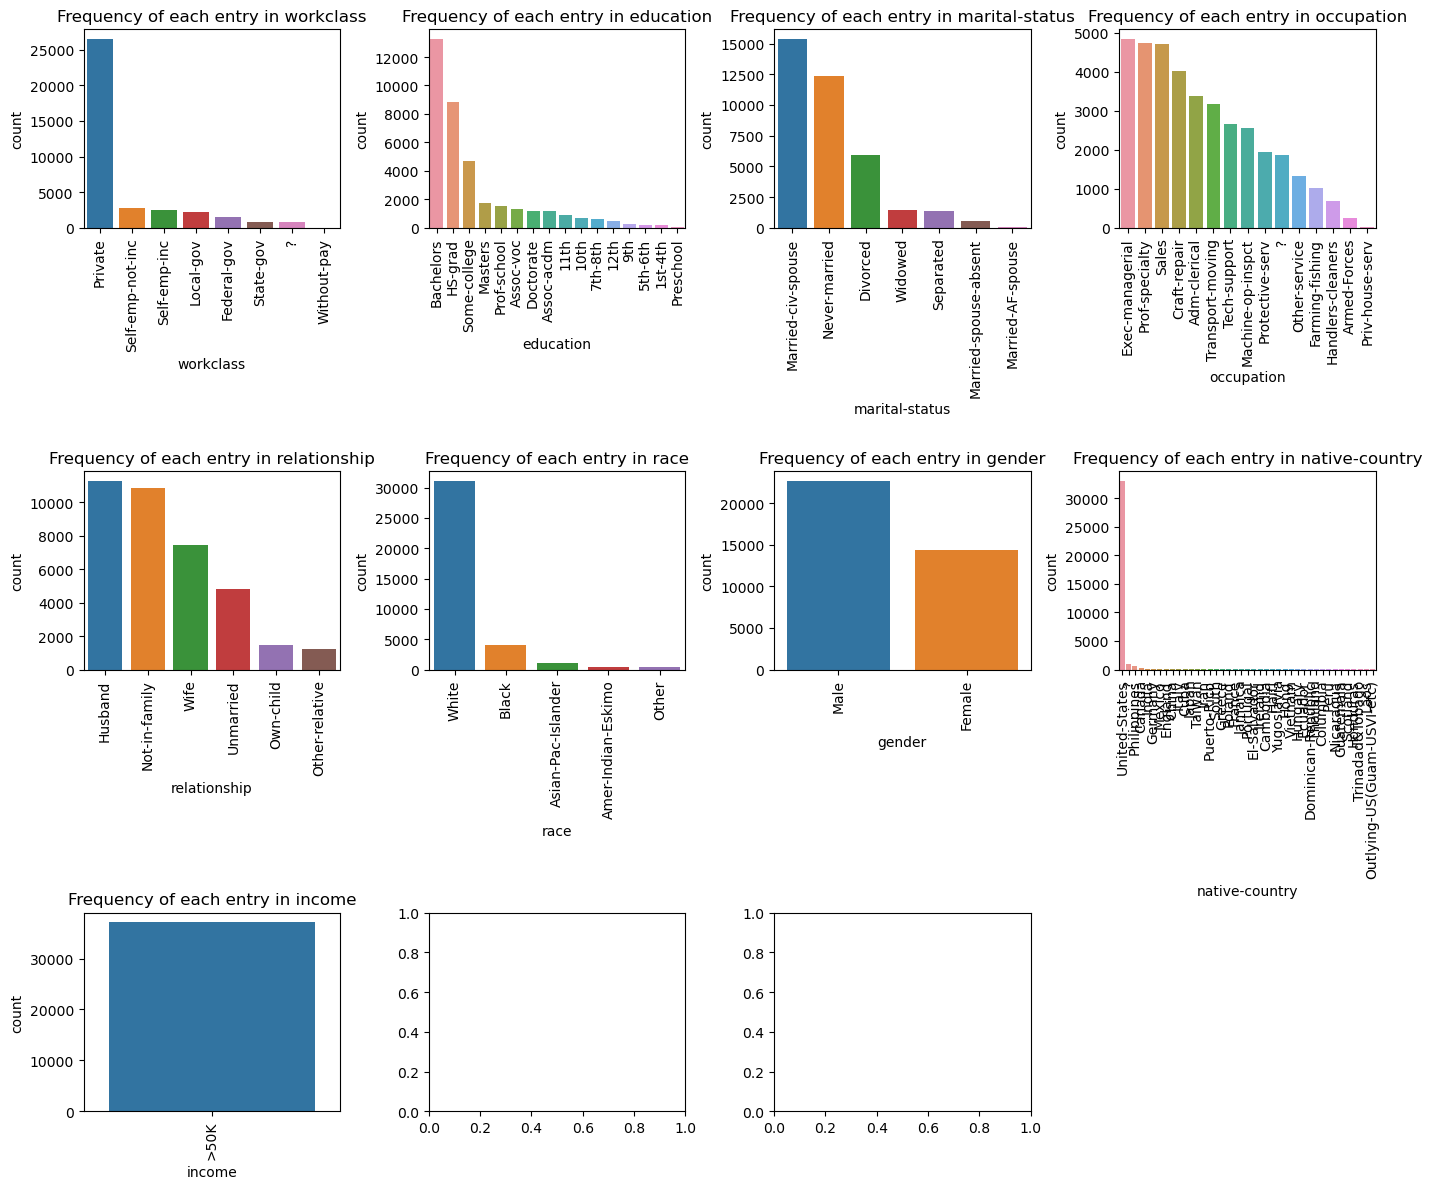

In [4]:
df_more50k = df[df['income'] == '>50K']
df_less50k = df[df['income'] == '<=50K']

columns_to_plot = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']

fig, axes = plt.subplots(3, 4, figsize=(14, 12))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.countplot(data=df_less50k, x=column, order=df_less50k[column].value_counts().index, ax=axes[i])
    sns.countplot(data=df_more50k, x=column, order=df_more50k[column].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Frequency of each entry in {column}')
    axes[i].tick_params(axis='x', rotation=90)

if len(columns_to_plot) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

* Age: The distribution shows a higher count of individuals in the younger age groups (20-30) earning <=50K. As age increases, the proportion of individuals earning >50K increases, peaking around 40-50 years old. The count then gradually decreases for both income groups as age increases further.

* Capital Gain: Most individuals have a capital gain of 0, which is represented by a large spike at the beginning of the distribution. There is a small subset of individuals with significant capital gains, and these are more likely to earn >50K. However, the majority of individuals with non-zero capital gains are still relatively few.

* Capital Loss: Similar to capital gain, most individuals have a capital loss of 0, with a sharp drop-off after this value. A very small portion of individuals report capital losses, and among these, those with non-zero capital losses are slightly more likely to earn >$50K, although the numbers are low.

* Hours Per Week: Most individuals work around 40 hours per week. There is a noticeable concentration of individuals earning >50K who work more than 40 hours, particularly around the 50-hour mark and above.
Those working less than 40 hours per week are predominantly in the <=50K category.

c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

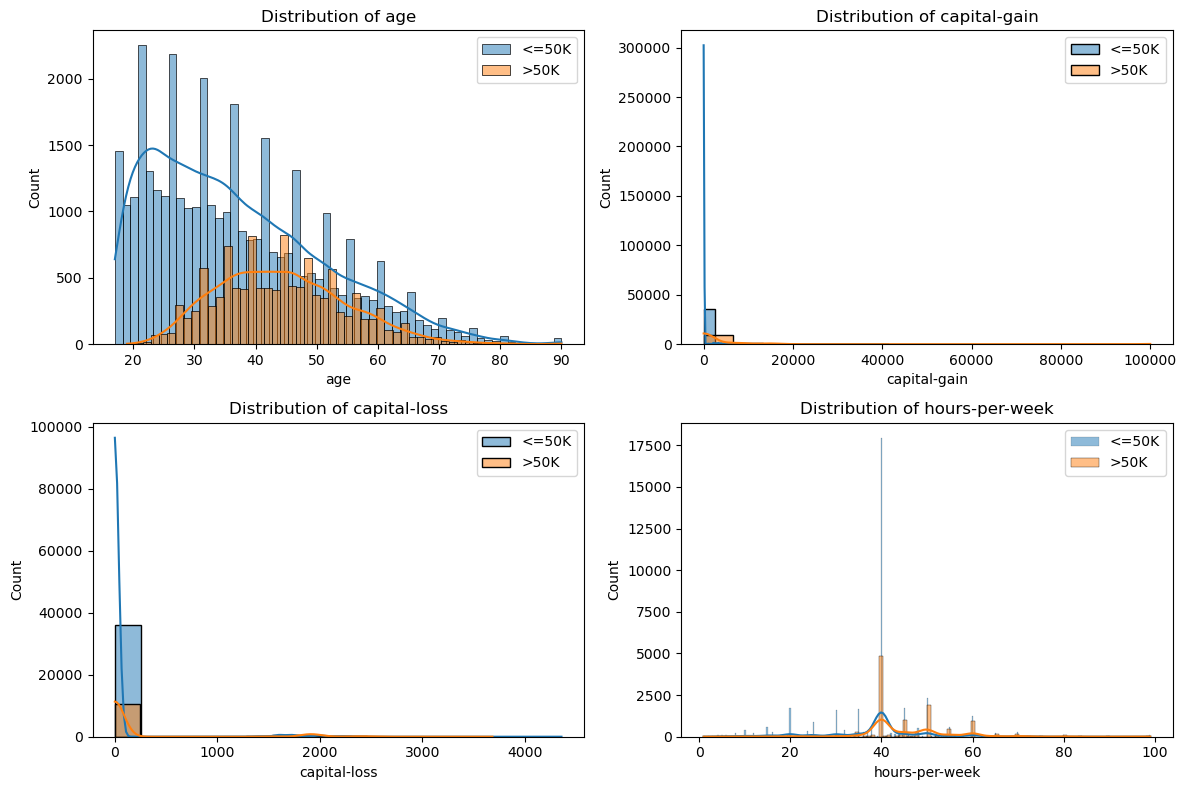

In [5]:
df_more50k = df[df['income'] == '>50K']
df_less50k = df[df['income'] == '<=50K']

numerical_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(data=df_less50k, x=column, ax=axes[i], label='<=50K', kde=True)
    sns.histplot(data=df_more50k, x=column, ax=axes[i], label='>50K', kde=True)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Sampling the dataset

We tried different iterations of the model, but it was taking hours to run, so we took a sample using stratified sampling. This method maintains the original distribution of the dataset, ensuring our sample is representative.We calculated the sample size to be 2289 entries, adjusted for a 98% confidence level and a 2% margin of error.

We decided to take 10% of the entries, resulting in a sample size of 4,800. This approach significantly reduces computation time while still providing a large enough sample to ensure the validity and reliability of our analysis.

In [6]:
import math

# Parameters
Z = 1.96  # Z-value for 95% confidence level
p = 0.5   # Estimated proportion
e = 0.02  # Desired margin of error

# Sample size calculation
n = (Z**2 * p * (1 - p)) / e**2
n = math.ceil(n)  # Round up to the next whole number

N = df.shape[0]  # Total number of observations
# Adjusted sample size for finite population
n_adj = n / (1 + (n - 1) / N)
n_adj = math.ceil(n_adj)

print("Required Sample Size:", n)
print("Adjusted Sample Size:", n_adj)

Required Sample Size: 2401
Adjusted Sample Size: 2289


In [7]:
X = df.drop(["income"], axis=1)
y = df["income"]

#just taking a sample

stratified_sample, _ = train_test_split(df, test_size=0.9, stratify=df['income'], random_state=1337)

# Distribution check
original_distribution = stratified_sample['income'].value_counts(normalize=True)
sample_distribution = stratified_sample['income'].value_counts(normalize=True)

print("Original Distribution:\n", original_distribution)
print("Sample Distribution:\n", sample_distribution)

Original Distribution:
 income
<=50K    0.760647
>50K     0.239353
Name: proportion, dtype: float64
Sample Distribution:
 income
<=50K    0.760647
>50K     0.239353
Name: proportion, dtype: float64


In [8]:
stratified_sample.shape

(4884, 15)

In [9]:
stratified_sample.head()

age     workclass  fnlwgt     education  educational-num  \
48002   30       Private  377017  Some-college               10   
27913   57       Private  161097       HS-grad                9   
32257   48       Private   28497       HS-grad                9   
38371   43  Self-emp-inc  104892       HS-grad                9   
8683    34       Private  312055     Bachelors               13   

           marital-status         occupation   relationship   race  gender  \
48002  Married-civ-spouse  Handlers-cleaners        Husband  White    Male   
27913            Divorced              Sales  Not-in-family  White  Female   
32257  Married-civ-spouse       Craft-repair        Husband  White    Male   
38371  Married-civ-spouse    Farming-fishing        Husband  White    Male   
8683        Never-married    Exec-managerial  Not-in-family  White    Male   

       capital-gain  capital-loss  hours-per-week native-country income  
48002             0             0              32  United-States  <=50K  
27913             0             0              26  United-States  <=50K  
32257             0             0              40  United-States  <=50K  
38371             0             0              45  United-States  <=50K  
8683              0             0              40  United-States   >50K

## Data preparation

**Columns** transformed: education, native country, workclass, race, and marital status.

In [10]:
education_mapping = {
    'Preschool': 'Compulsory',
    '1st-4th': 'Compulsory',
    '5th-6th': 'Compulsory',
    '7th-8th': 'Compulsory',
    '9th': 'Compulsory',
    '10th': 'Compulsory',
    '11th': 'Compulsory',
    '12th': 'Compulsory',
    'HS-grad': 'High School',
    'Some-college': 'High School',
    'Assoc-voc': 'Associate',
    'Assoc-acdm': 'Associate',
    'Bachelors': 'College',
    'Masters': 'Post Graduate',
    'Prof-school': 'Post Graduate',
    'Doctorate': 'Post Graduate'
}

# Apply the mapping to the 'education' column
stratified_sample['education_grouped'] = stratified_sample['education'].map(education_mapping)

In [11]:
# Iterate over each row in the DataFrame
for index, row in stratified_sample.iterrows():
    if row['native-country'] == 'United-States':
        stratified_sample.loc[index, 'native-country'] = 'United States' # Update the value in the 'native-country' column for this row
    else:
        stratified_sample.loc[index, 'native-country'] = 'Other' # Update the value in the 'native-country' column for this row

stratified_sample['native-country'].value_counts()

native-country
United States    4426
Other             458
Name: count, dtype: int64

In [12]:
# Iterate over each row in the DataFrame
for index, row in stratified_sample.iterrows():
    if row['race'] == 'White':
        stratified_sample.loc[index, 'race'] = 'White'
    elif row['race'] == 'Black':
        stratified_sample.loc[index, 'race'] = 'Black'     # Update the value in the 'native-country' column for this row
    else:
        stratified_sample.loc[index, 'race'] = 'Other' # Update the value in the 'native-country' column for this row

stratified_sample['race'].value_counts()

race
White    4197
Black     491
Other     196
Name: count, dtype: int64

In [13]:
stratified_sample['workclass'] = stratified_sample['workclass'].replace(['Never-worked', 'Without-pay'], 'Never-worked-or-Without-pay')

In [14]:
stratified_sample['marital-status'] = stratified_sample['marital-status'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'Married')
stratified_sample['marital-status'].value_counts()

marital-status
Married                  2215
Never-married            1609
Divorced                  682
Widowed                   171
Separated                 147
Married-spouse-absent      60
Name: count, dtype: int64

### Insights from Categorical Variables Distribution

1. **Workclass:**
   - The "Private" workclass is the most common, with a majority earning <=50K.
   - Self-employed individuals and those in the "Federal-gov" category have a relatively higher proportion of individuals earning >50K.

2. **Education and Education Grouped:**
   - The "HS-grad" category is the most common, with a large proportion earning <=50K.
   - Individuals with "Bachelors" and higher education levels (grouped under "College," "Associate," "Post Graduate") have a higher proportion of earning >50K.
   - The "Compulsory" and "High School" categories predominantly consist of individuals earning <=50K.

3. **Marital Status:**
   - The "Married-civ-spouse" category has a significant portion earning >50K, indicating a correlation between being married and higher income.
   - "Never-married" individuals mostly earn <=50K, similar to those who are "Divorced" or "Separated."

4. **Occupation:**
   - Occupations like "Exec-managerial," "Prof-specialty" have a higher proportion of individuals earning >50K.
   - "Handlers-cleaners," "Priv-house-serv," and "Other-service" occupations are primarily in the <=50K category.

5. **Relationship:**
   - "Husband" is the most common relationship status among those earning >50K, while "Not-in-family" and "Own-child" are predominantly <=50K.
   - There is a relatively balanced distribution between income levels among "Husband" and "Wife" categories.

6. **Race:**
   - The dataset is predominantly composed of individuals who identify as "White," with a higher proportion earning >50K.
   - Other racial categories have a lower proportion of individuals earning >50K, with "Black" and "Asian-Pac-Islander" being the next most common.

7. **Gender:**
   - Males are more represented in the >50K income group compared to females, indicating a gender disparity in income levels.

8. **Native Country:**
   - The vast majority of the dataset is composed of individuals from the United States, with the majority earning <=50K.
   - There is a small proportion of individuals from "Other" countries, with fewer earning >50K.

9. **Income:**
   - The dataset shows a higher count of individuals earning <=50K compared to >50K, indicating an imbalance in income distribution.

### General Observations:
- **Income and Demographic Correlations:** Higher income levels (>50K) are associated with being married, having higher education, and certain occupations like executive and professional roles. There is also a noticeable gender disparity, with more males in the higher income group.
- **Education Levels:** Higher education levels correlate with higher income, as seen in both the detailed and grouped education categories.
- **Race and Income:** There is a predominant representation of the "White" racial group, with a notable portion earning >50K, suggesting potential socioeconomic disparities.

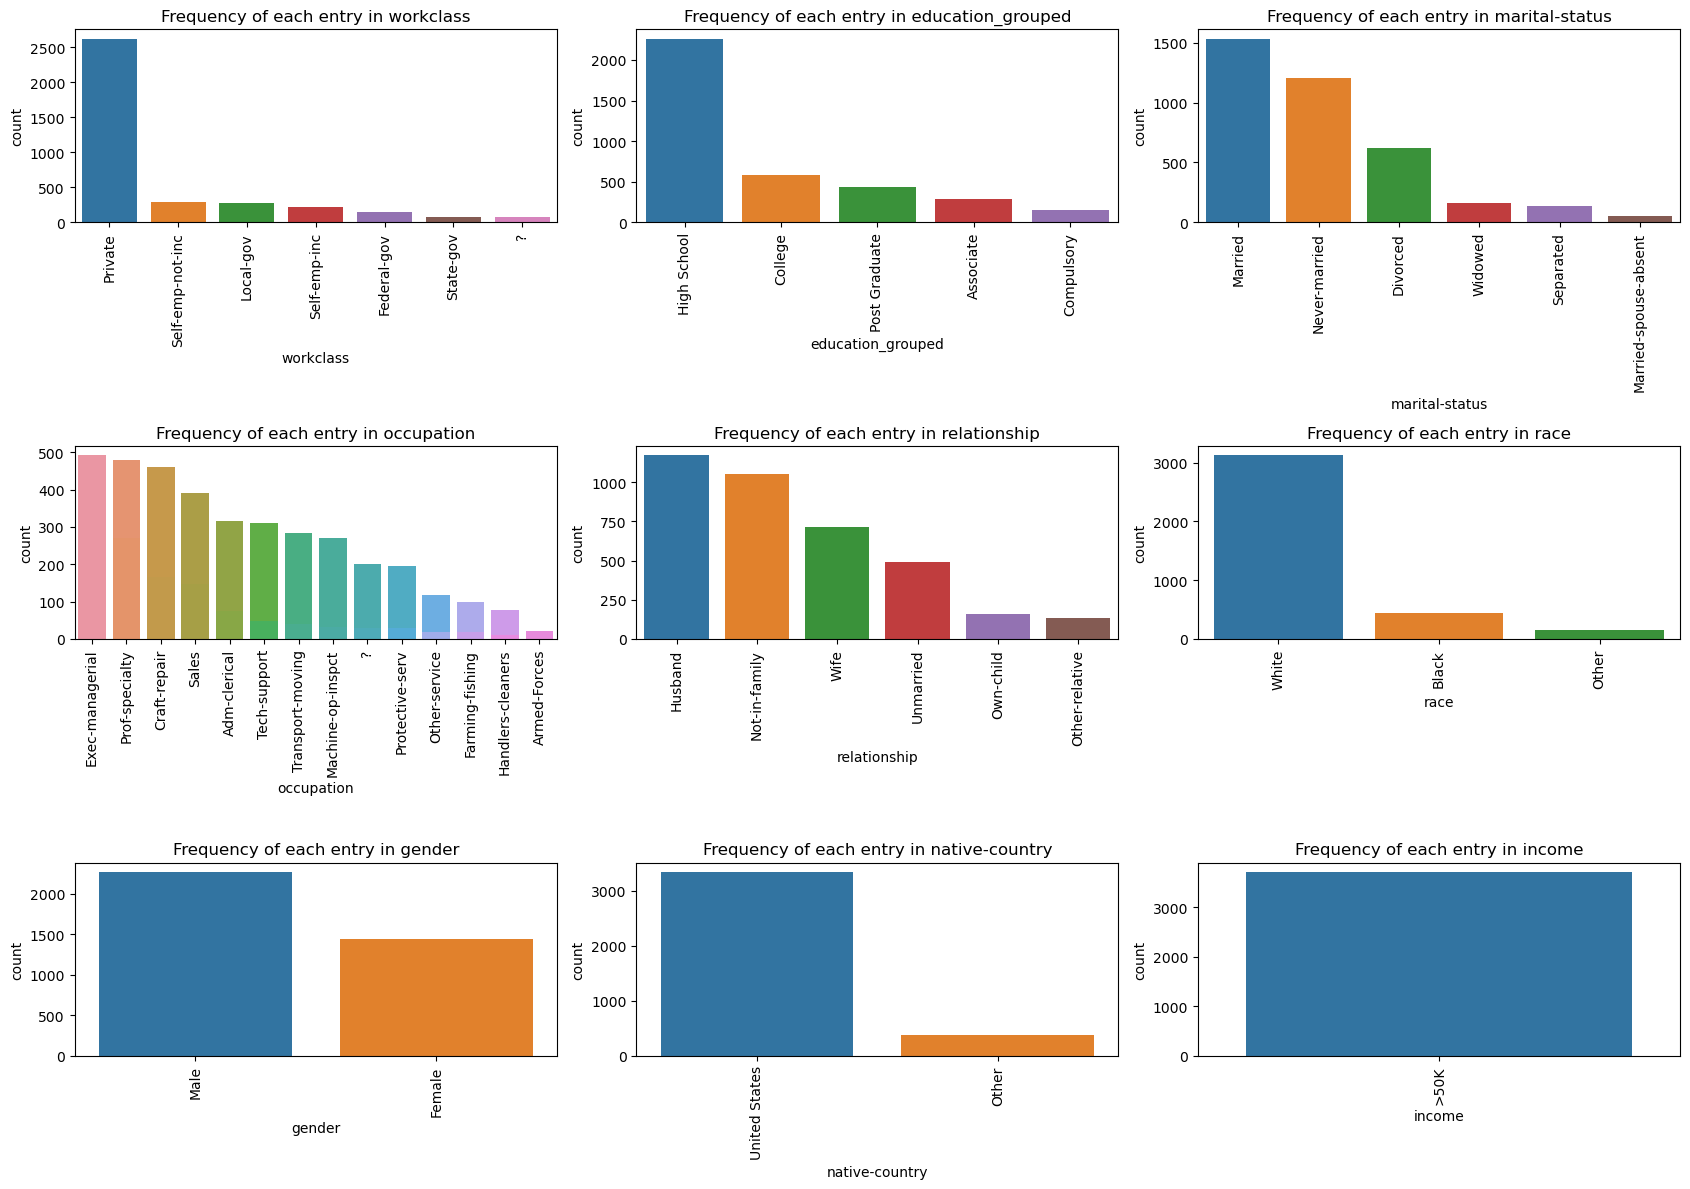

In [15]:
df_more50k = stratified_sample[stratified_sample['income'] == '>50K']
df_less50k = stratified_sample[stratified_sample['income'] == '<=50K']

columns_to_plot = ['workclass', 'education_grouped', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']

fig, axes = plt.subplots(3, 3, figsize=(17, 12))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.countplot(data=df_less50k, x=column, order=df_less50k[column].value_counts().index, ax=axes[i])
    sns.countplot(data=df_more50k, x=column, order=df_more50k[column].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Frequency of each entry in {column}')
    axes[i].tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()

c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jasiado\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

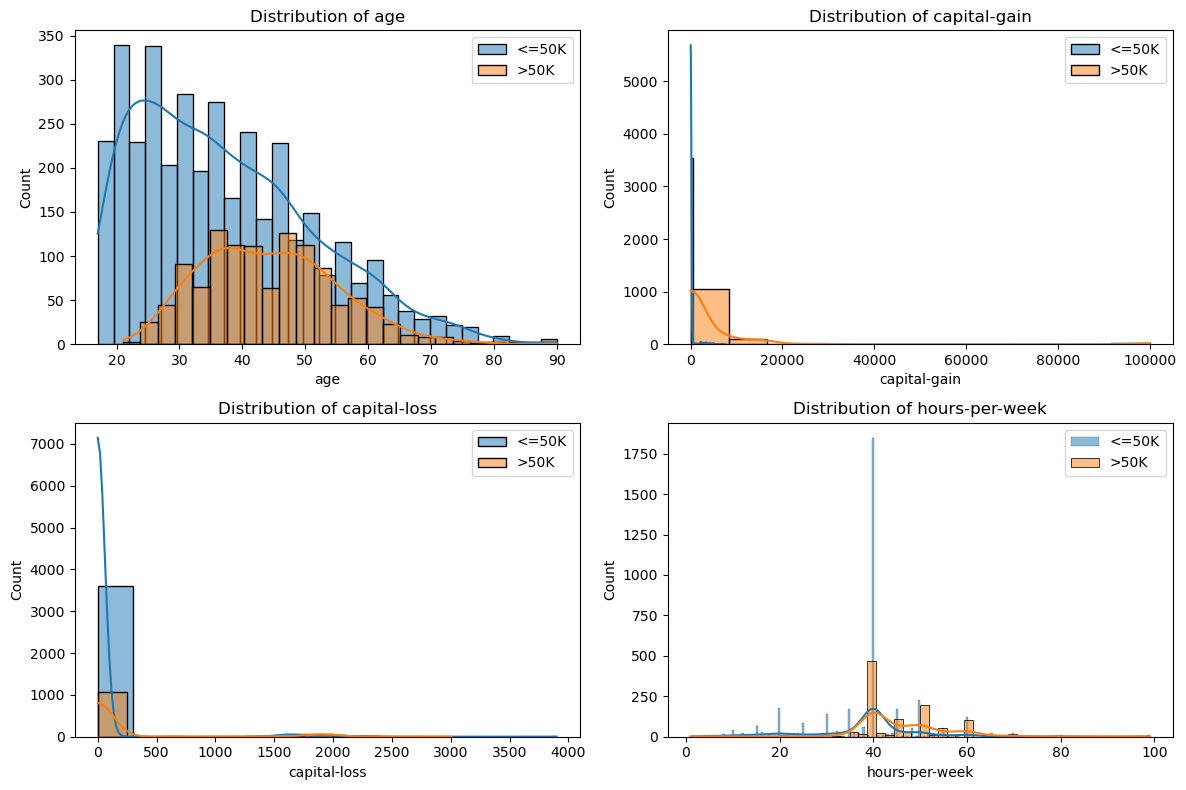

In [16]:
df_more50k = stratified_sample[stratified_sample['income'] == '>50K']
df_less50k = stratified_sample[stratified_sample['income'] == '<=50K']

numerical_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(data=df_less50k, x=column, ax=axes[i], label='<=50K', kde=True)
    sns.histplot(data=df_more50k, x=column, ax=axes[i], label='>50K', kde=True)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler

numerical_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'marital-status', 'education_grouped', 'occupation', 'relationship', 'race', 'gender', 'income']

for i in stratified_sample.columns:
    stratified_sample[i].replace({"?":"Not-specified"},inplace=True)

std_scaler = MinMaxScaler()
stratified_sample[numerical_cols] = std_scaler.fit_transform(stratified_sample[numerical_cols])

# le = LabelEncoder()
# stratified_sample['education_grouped_encoded'] = le.fit_transform(stratified_sample['education_grouped'])

df_final = pd.concat([stratified_sample[numerical_cols], stratified_sample[categorical_cols]], axis=1)

# One-hot encode categorical columns
data = pd.get_dummies(df_final, columns=categorical_cols, drop_first=True)

<Axes: >

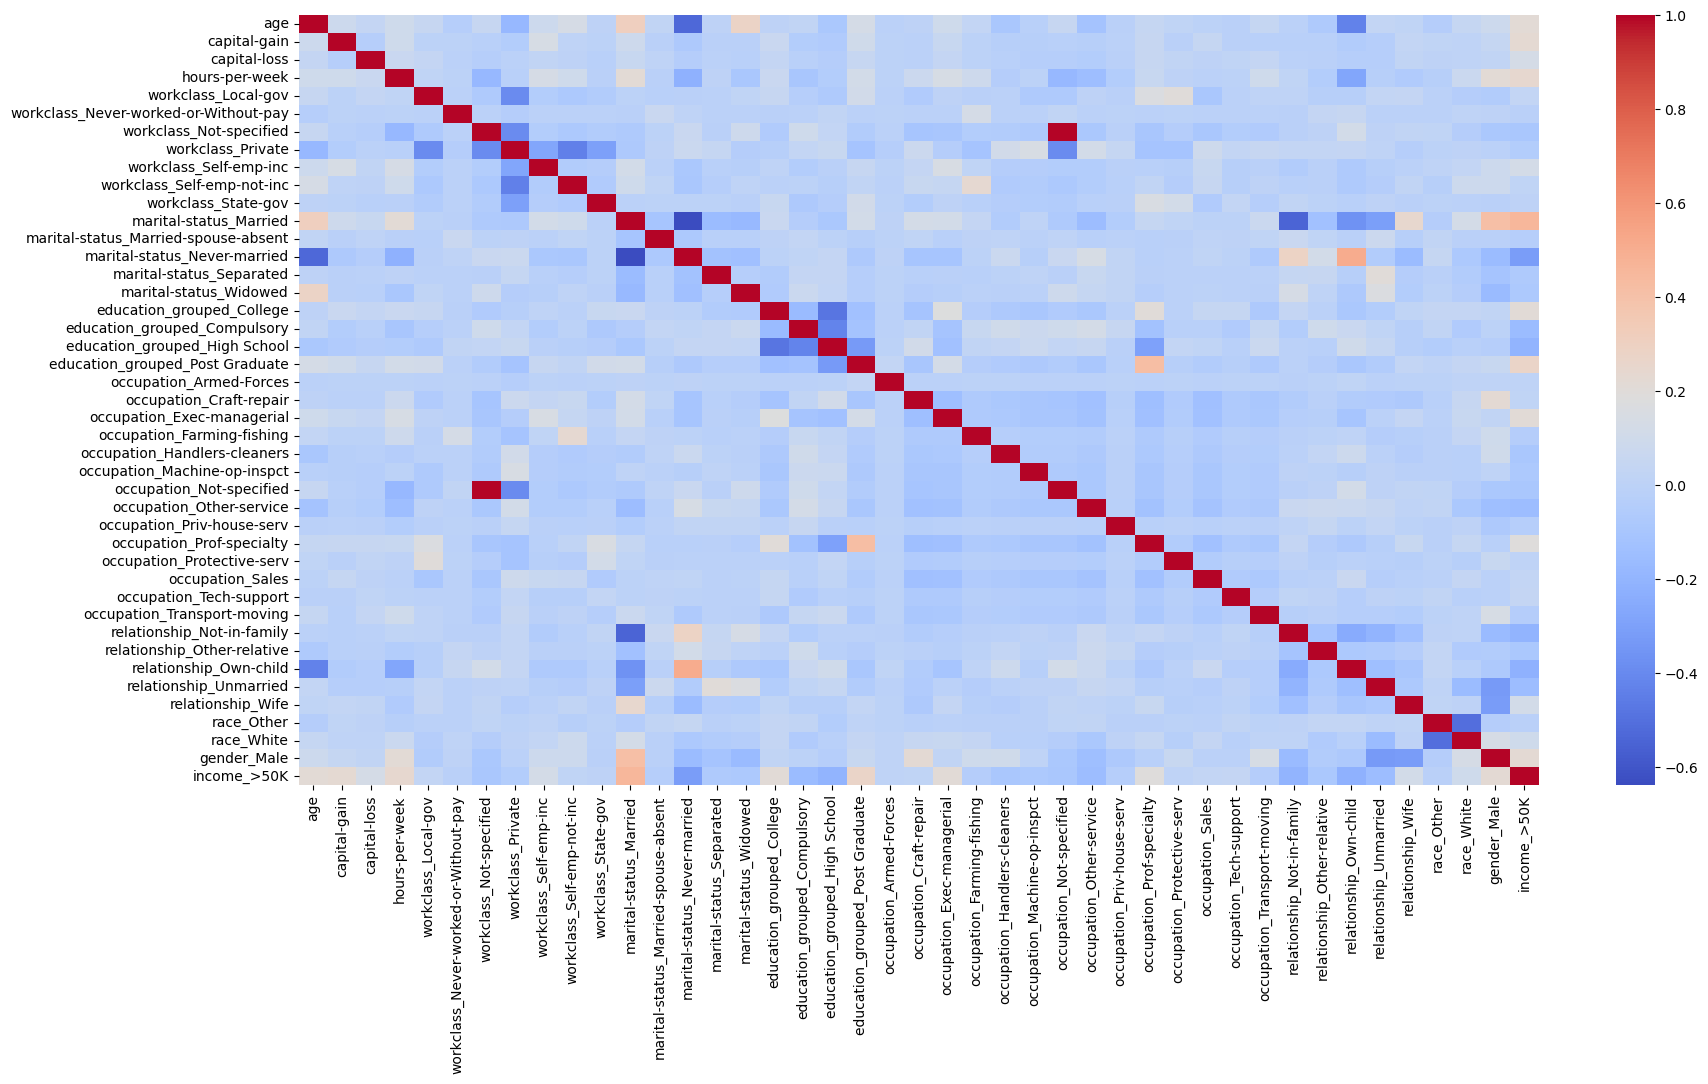

In [18]:
plt.figure(figsize=(20,10))

sns.heatmap(data.corr(),annot=False,cmap='coolwarm')

In [19]:
correlation_matrix = data.corr().abs()

# Find the pairs of features with correlation above 0.7
high_correlation_pairs = []

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.6:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            high_correlation_pairs.append((col1, col2, correlation_value))

# Output the results
for col1, col2, correlation_value in high_correlation_pairs:
    print(f"{col1} and {col2} have a correlation of {correlation_value}")

workclass_Not-specified and occupation_Not-specified have a correlation of 0.998292085491947
marital-status_Married and marital-status_Never-married have a correlation of 0.6385353544098928


In [20]:
data.drop(["workclass_Not-specified"], axis=1, inplace=True)

## PCA for visualization



In [21]:
X_2 = data
y_2 = data["income_>50K"]

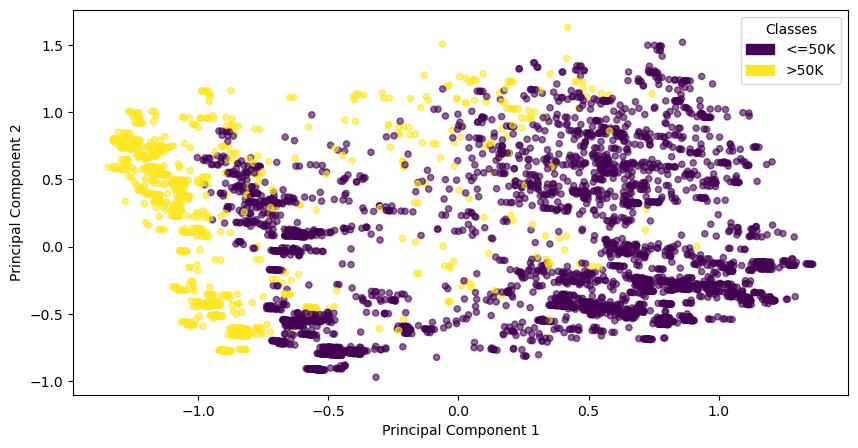

In [22]:
import plotly.express as px
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches


pca = PCA(n_components=10)
components = pca.fit_transform(X_2)

plt.figure(figsize=(10, 5))
scatter = plt.scatter(components[:, 0], components[:, 1], c=y_2, s=20, cmap='viridis', alpha=0.6)

# Add legend
custom_labels = ['<=50K', '>50K']
unique_classes = np.unique(y_2)
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(class_value)), label=label)
           for class_value, label in zip(unique_classes, custom_labels)]

# Add legend with custom handles and labels
plt.legend(handles=handles, title="Classes", loc="upper right")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [23]:
pip install scikit-learn-extra

Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from sklearn.base import clone
from numpy.testing import (assert_equal, assert_almost_equal,
                           assert_array_almost_equal)
from IPython.display import HTML

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cdist

In [25]:
import warnings
warnings.filterwarnings("ignore")

#Representative-based clustering

## KMeans

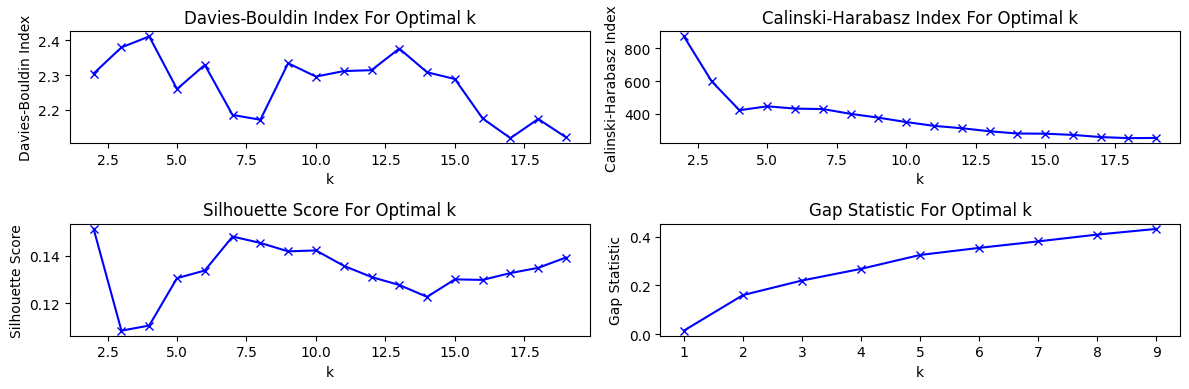

In [ ]:
def compute_gap_statistic(X, n_refs=5, max_clusters=10):

    gaps = np.zeros(max_clusters-1)
    results = []

    for k in range(1, max_clusters):
        refDisps = np.zeros(n_refs)

        for i in range(n_refs):
            randomReference = np.random.random_sample(size=X.shape)
            km = KMeans(k)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp

        km = KMeans(k)
        km.fit(X)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[k-1] = gap

        results.append({'clusterCount': k, 'gap': gap})

    resultsdf = pd.DataFrame(results)
    return gaps, resultsdf

dbi_scores = []
ch_scores = []
silhouette_scores = []
gap_scores, gap_results = compute_gap_statistic(X_2, n_refs=5, max_clusters=10)
K = range(2, 20)

for k in K:
    kmeans_census = KMeans(n_clusters=k, random_state=42, n_init='auto')
    y_pred = kmeans_census.fit_predict(X_2)

    dbi_score = davies_bouldin_score(X_2, y_pred)
    dbi_scores.append(dbi_score)

    ch_score = calinski_harabasz_score(X_2, y_pred)
    ch_scores.append(ch_score)

    silhouette_avg = silhouette_score(X_2, y_pred)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 4))

plt.subplot(2, 2, 1)
plt.plot(K, dbi_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index For Optimal k')

plt.subplot(2, 2, 2)
plt.plot(K, ch_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index For Optimal k')

plt.subplot(2, 2, 3)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.subplot(2, 2, 4)
plt.plot(range(1, 10), gap_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic For Optimal k')

plt.tight_layout()
plt.show()

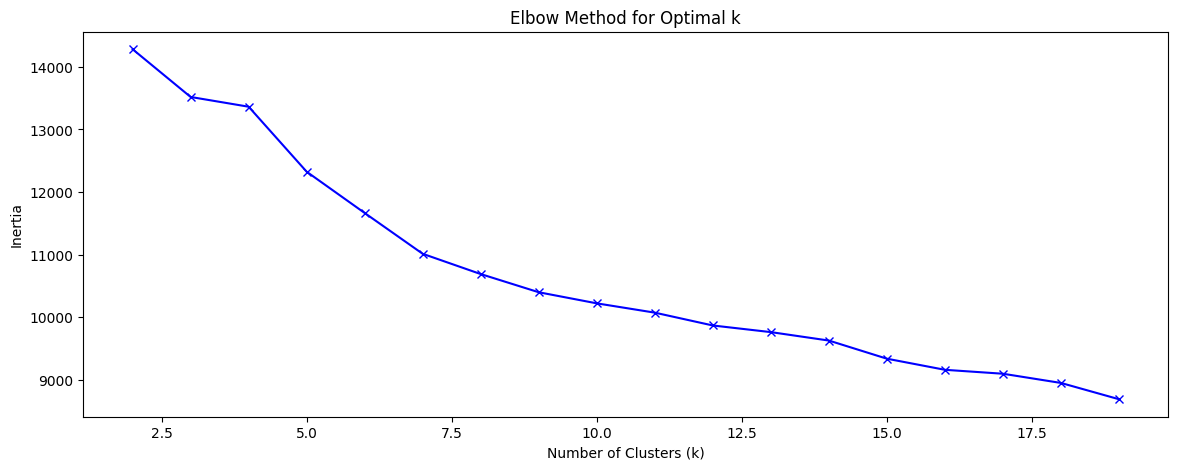

In [ ]:
inertia_values = []

# Try different values of k
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_2)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(14, 5))
plt.plot(k_range, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

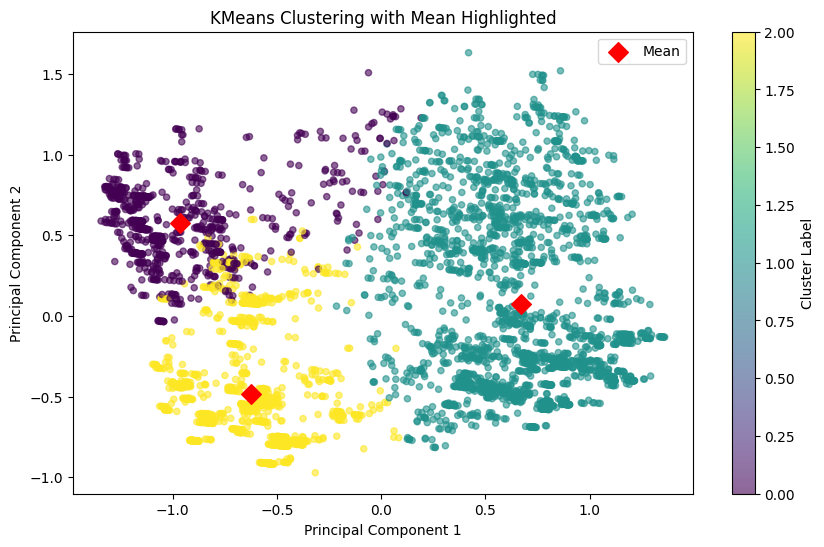

In [ ]:
kmeans_census = KMeans(n_clusters=3, random_state=42, n_init='auto')
y_predict_census = kmeans_census.fit_predict(X_2)

mean_indices = kmeans_census.cluster_centers_ # This gives you coordinates, not indices
mean_pca = pca.transform(mean_indices) # Directly transform the coordinates

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=y_predict_census, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.scatter(
    mean_pca[:, 0], mean_pca[:, 1],
    color='red', marker='D', s=100, label='Mean'  # Marker style, size, and label
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with Mean Highlighted')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

In [ ]:
k_value = 3

# Find the index corresponding to k=3
k_index = k_value - 2  # K range starts from 2, so index for k=3 is 1

# Extract metrics for k=3
dbi_k3 = dbi_scores[k_index]
ch_k3 = ch_scores[k_index]
silhouette_k3 = silhouette_scores[k_index]
gap_k3 = gap_scores[k_value - 1]  # Gap statistic index corresponds directly to k

# Print the metrics
print(f"Metrics for k={k_value}:")
print(f"Davies-Bouldin Index: {dbi_k3:.4f}")
print(f"Calinski-Harabasz Index: {ch_k3:.4f}")
print(f"Silhouette Score: {silhouette_k3:.4f}")
print(f"Gap Statistic: {gap_k3:.4f}")

Metrics for k=3:
Davies-Bouldin Index: 2.3796
Calinski-Harabasz Index: 599.2416
Silhouette Score: 0.1085
Gap Statistic: 0.2202


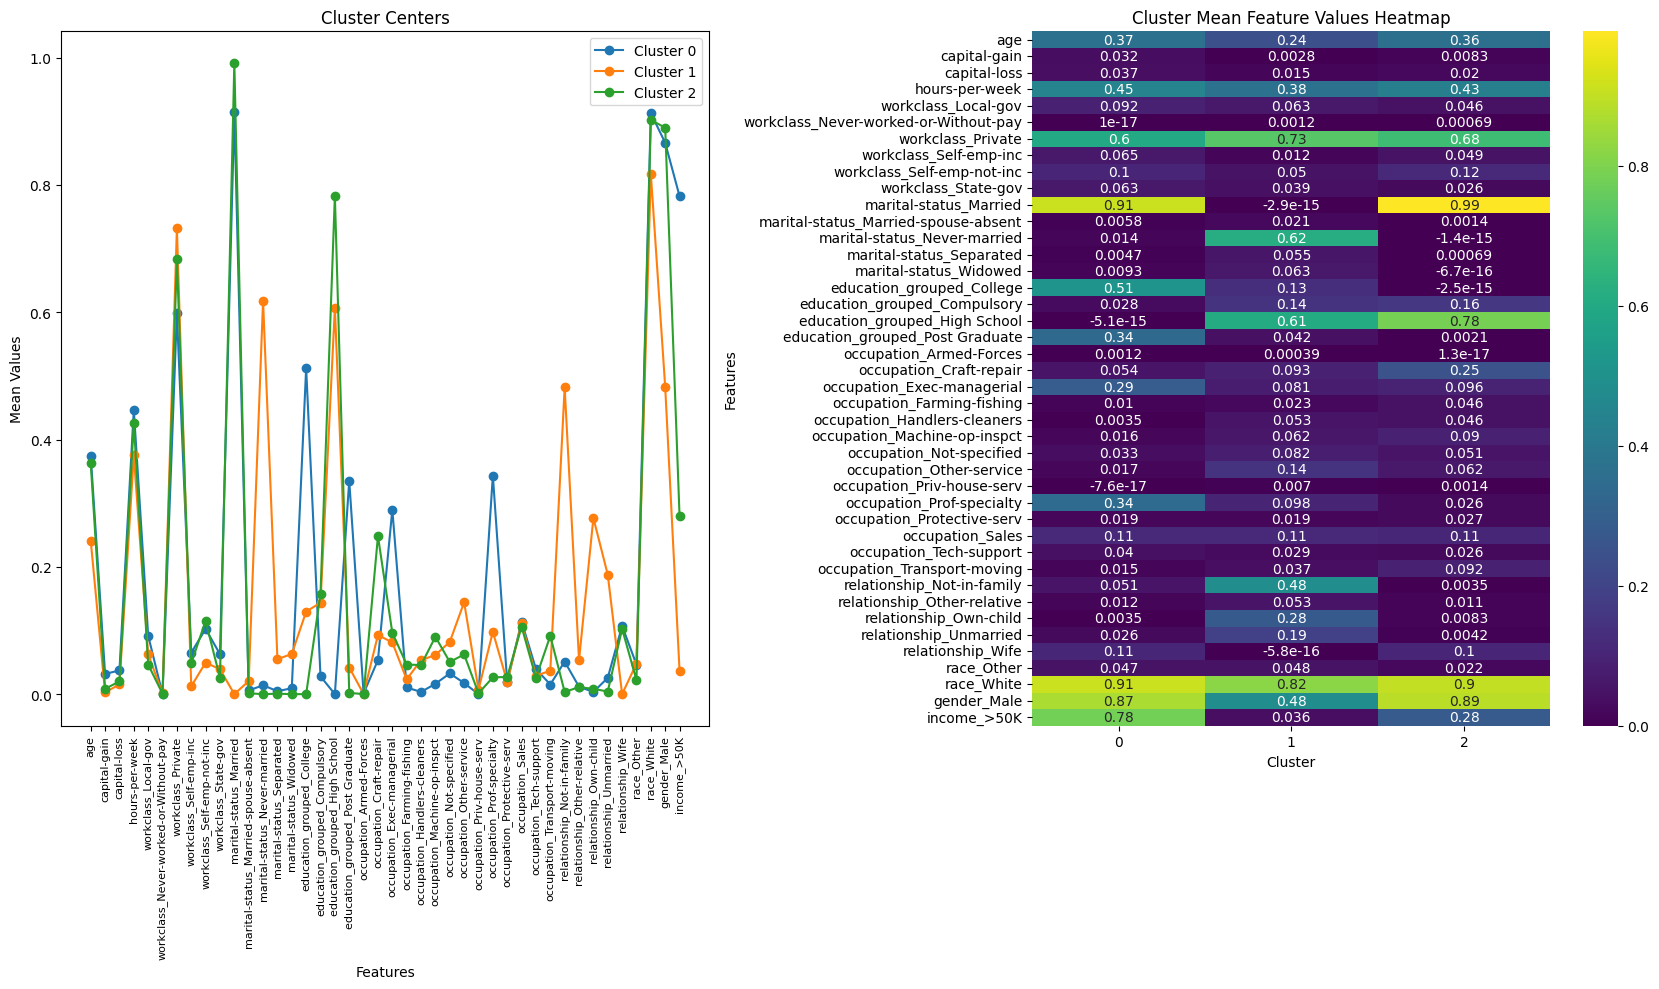

In [ ]:
# Just wanted to check for explainability
mean = kmeans_census.cluster_centers_
mean_df = pd.DataFrame(mean, columns=X_2.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 10))
for i in range(len(mean)):
    ax1.plot(mean_df.columns, mean_df.iloc[i], marker='o', label=f'Cluster {i}')
ax1.set_title('Cluster Centers')
ax1.set_xlabel('Features')
ax1.set_ylabel('Mean Values')
ax1.legend()
ax1.set_xticklabels(mean_df.columns, rotation=90, fontsize=8)

sns.heatmap(mean_df.T, annot=True, cmap="viridis", ax=ax2)
ax2.set_title('Cluster Mean Feature Values Heatmap')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Features')

plt.tight_layout()
plt.show()

**General Observations:**
* Cluster 0: This cluster is characterized by features such as higher proportions in relationship_Husband, income_>50K, and occupation_Exec-managerial. It has notable values for education_grouped_College, education_grouped_High School, gender_Male, and workclass_Private.

* Cluster 1: This cluster shows high values for marital-status_Married-civ-spouse and relationship_Husband. It also has higher capital-gain, hours-per-week, and features indicating more representation in managerial roles (occupation_Exec-managerial, occupation_Prof-specialty). It seems to correspond to individuals with stable employment and higher incomes.

* Cluster 2: This cluster shows higher representation in relationship_Not-in-family and relationship_Other-relative, with lower values for income_>50K and gender_Male. It has some distinctive peaks in features like workclass_Never-worked, workclass_Local-gov, and workclass_State-gov, suggesting diversity in employment status and potentially lower incomes.

**Interpretation:**

* Cluster 0: This cluster could represent more affluent and professionally established individuals, likely to have managerial or specialist roles.
* Cluster 1: This group might include individuals in stable relationships with stable but possibly less high-paying jobs, possibly reflecting a middle-class demographic.
* Cluster 2: This cluster might represent more diverse employment statuses and relationship situations, possibly including lower-income individuals and those with varied or uncertain job situations.

### We also wanted to see if a 2-cluster method would be representative of the two income categories

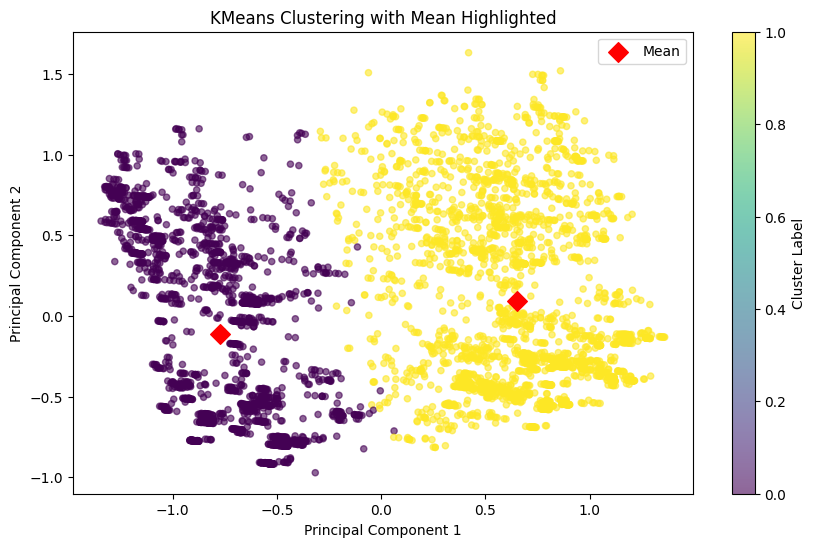

In [ ]:
kmeans_census = KMeans(n_clusters=2, random_state=1337, n_init='auto')
y_predict_census = kmeans_census.fit_predict(X_2)

mean_indices = kmeans_census.cluster_centers_ # This gives you coordinates, not indices
mean_pca = pca.transform(mean_indices) # Directly transform the coordinates

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=y_predict_census, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.scatter(
    mean_pca[:, 0], mean_pca[:, 1],
    color='red', marker='D', s=100, label='Mean'  # Marker style, size, and label
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with Mean Highlighted')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

#### Testing per feature

In [ ]:
df_more50k = data[data['income_>50K'] == True]
df_less50k = data[data['income_>50K'] == False]
stratified_sample['rep_cluster'] = y_predict_census

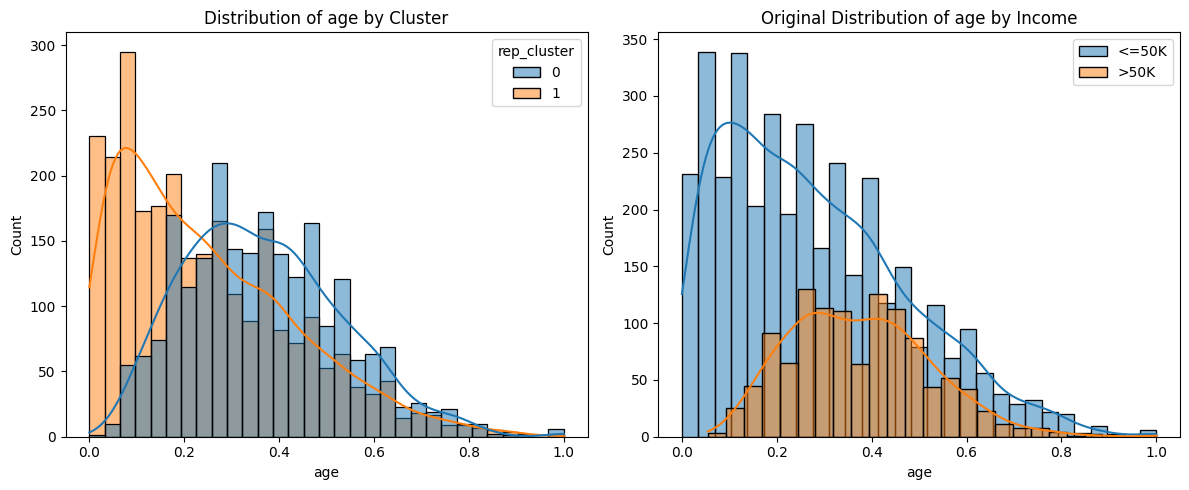

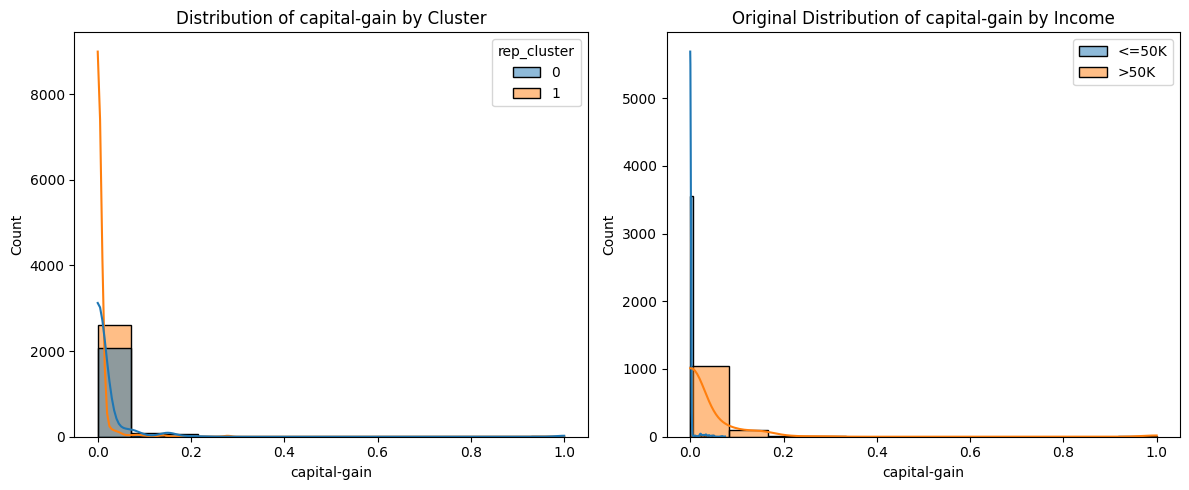

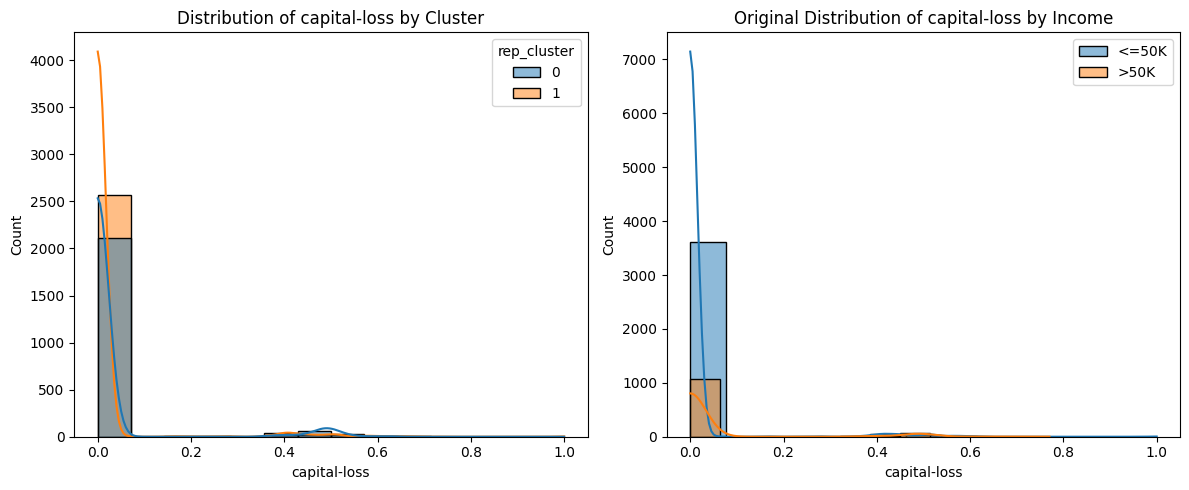

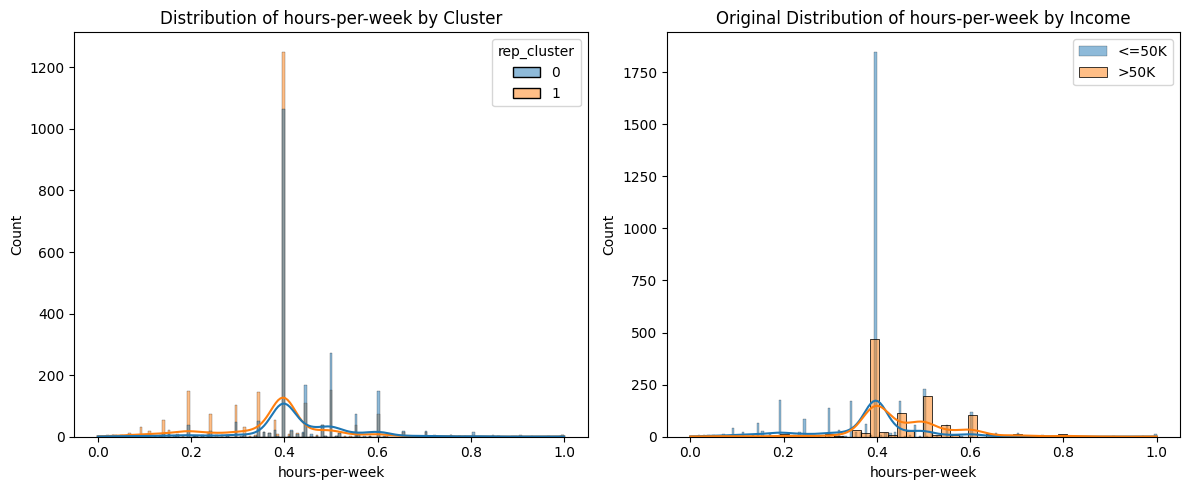

In [ ]:
for feature in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot distribution by cluster
    sns.histplot(data=stratified_sample, x=feature, hue='rep_cluster', kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {feature} by Cluster')

    # Plot original distribution by income
    sns.histplot(data=df_less50k, x=feature, label='<=50K', kde=True, ax=axes[1])
    sns.histplot(data=df_more50k, x=feature, label='>50K', kde=True, ax=axes[1])
    axes[1].set_title(f'Original Distribution of {feature} by Income')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

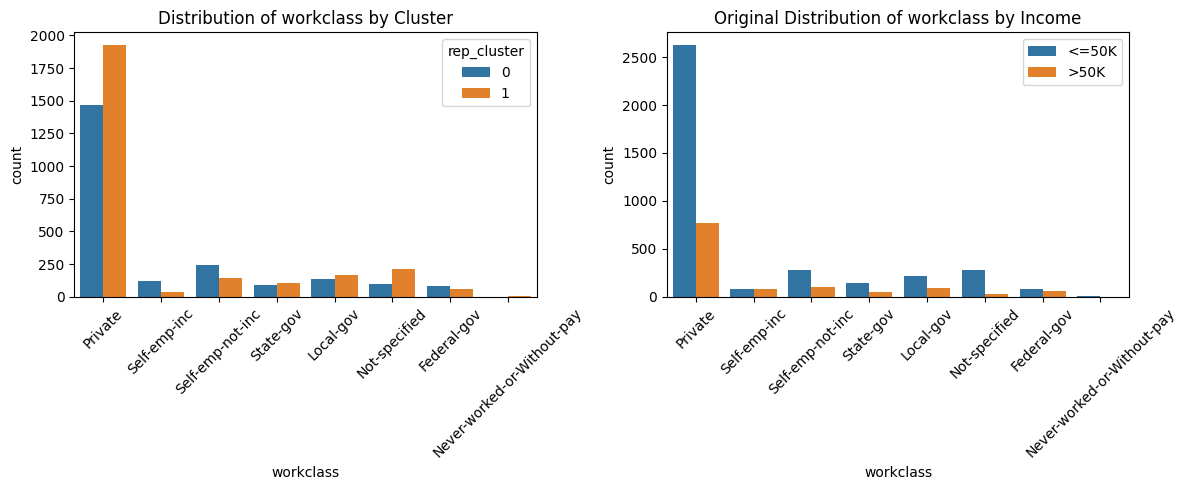

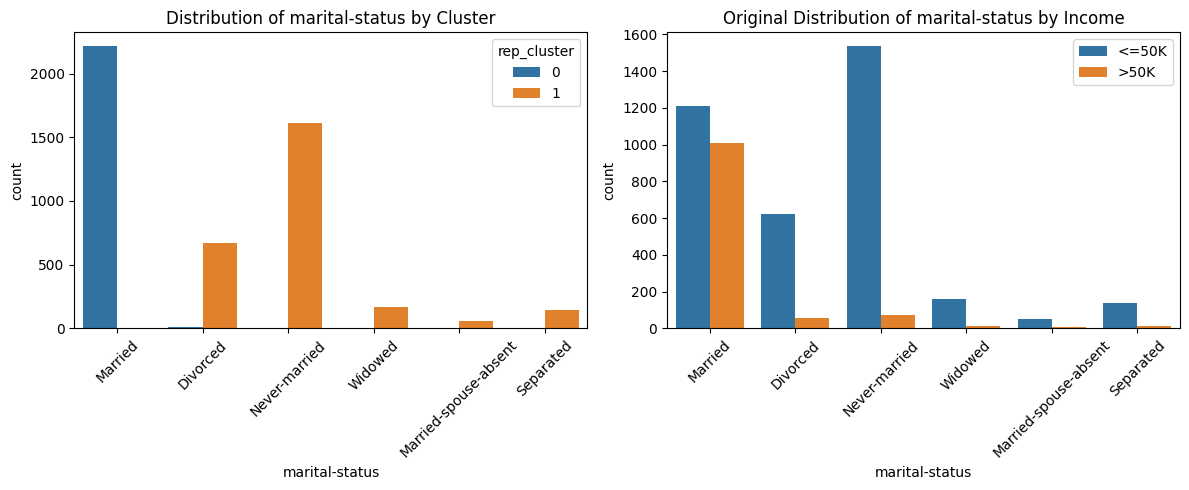

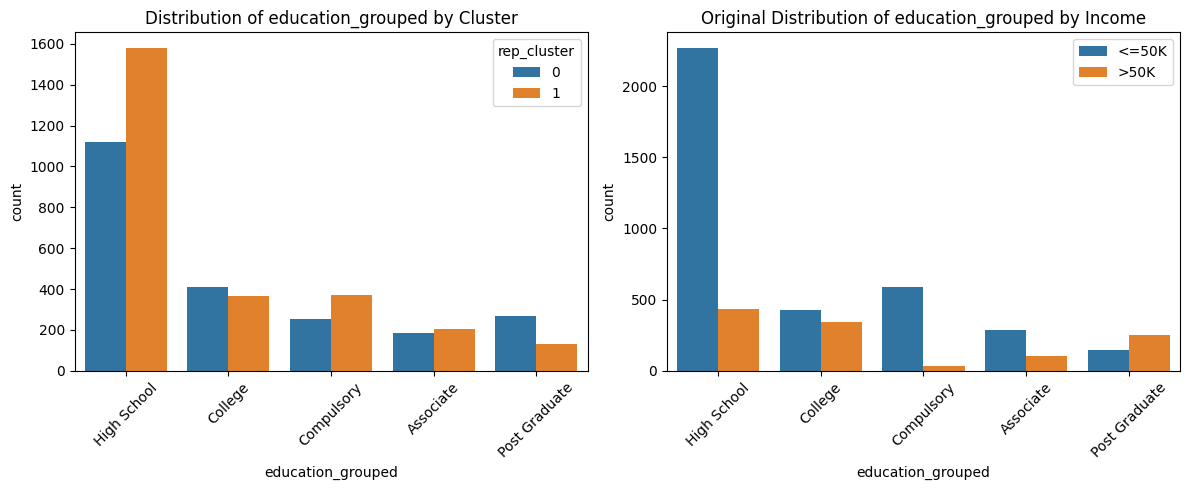

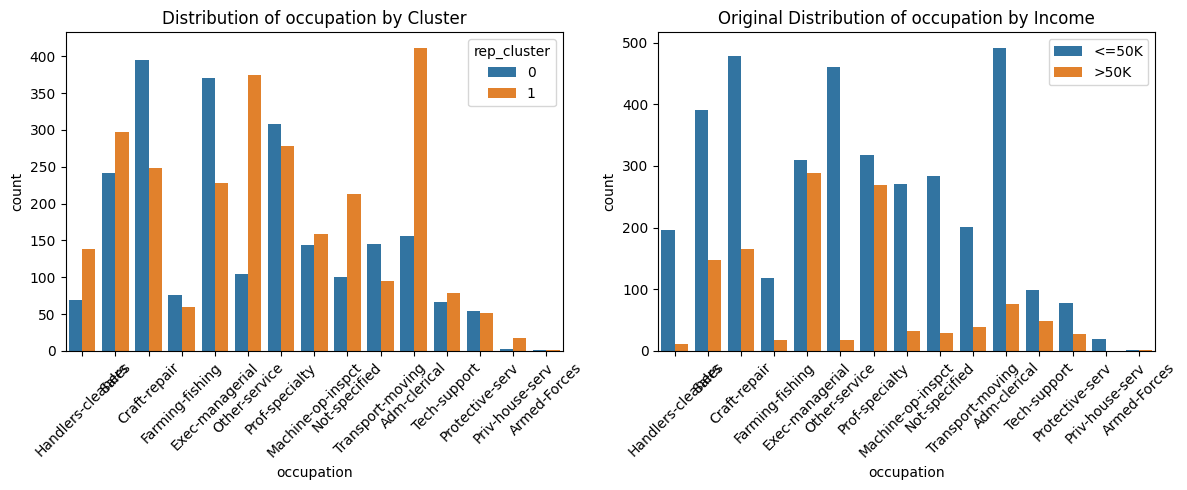

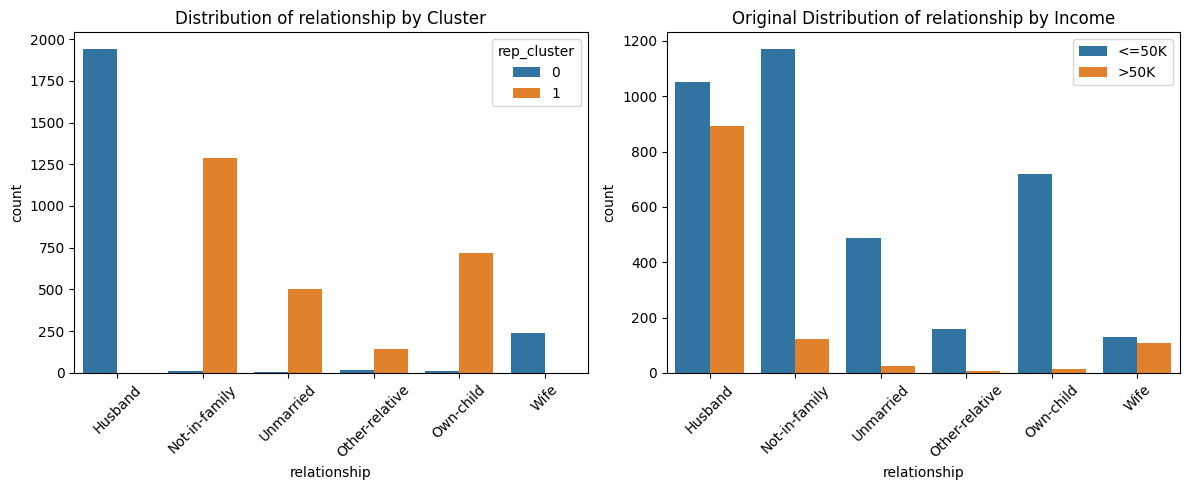

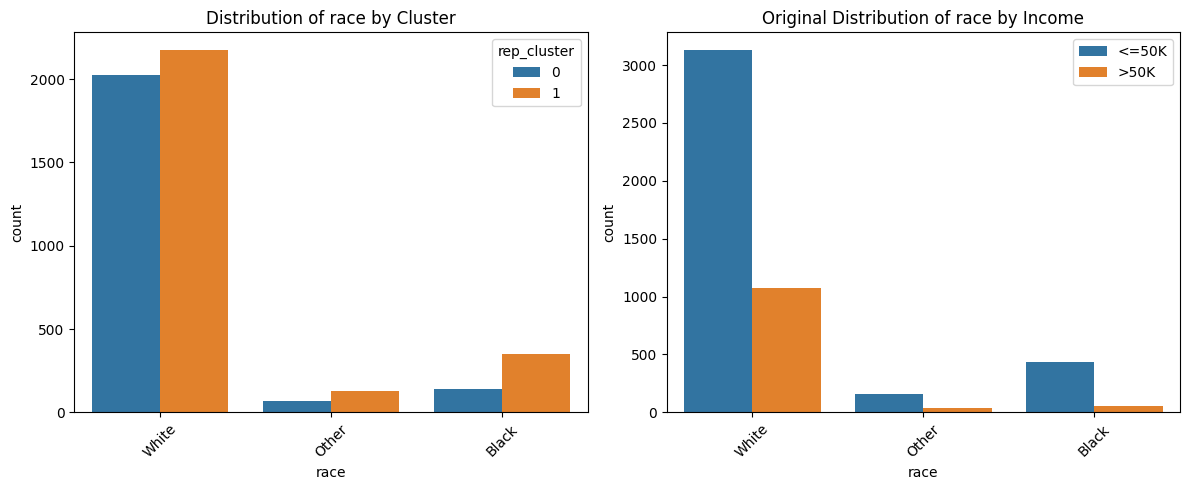

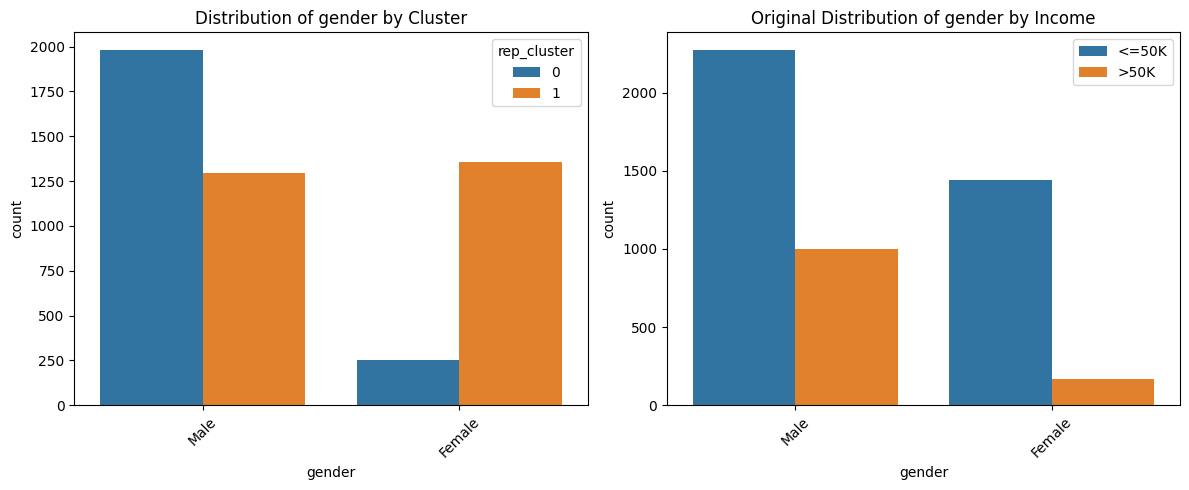

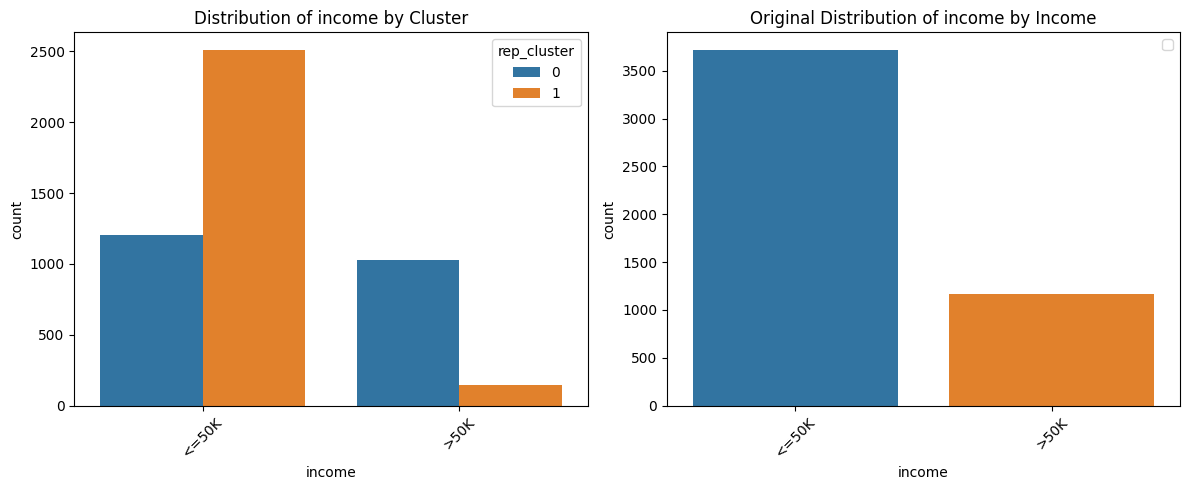

In [ ]:
for feature in categorical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot distribution by cluster
    sns.countplot(data=stratified_sample, x=feature, hue='rep_cluster', ax=axes[0])
    axes[0].set_title(f'Distribution of {feature} by Cluster')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot original distribution by income
    sns.countplot(data=stratified_sample, x=feature, hue='income', ax=axes[1])
    axes[1].set_title(f'Original Distribution of {feature} by Income')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

#### Checking for 2 clusters



In [ ]:
stratified_sample['rep_cluster'] = y_predict_census

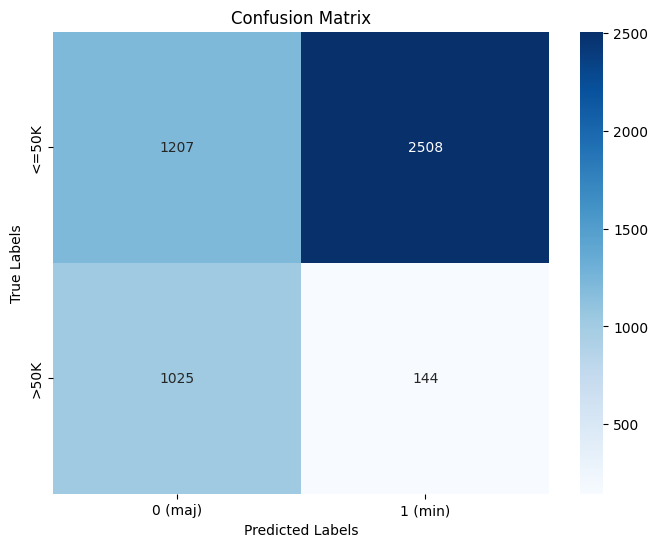

In [ ]:
true_labels = data['income_>50K']

# Get the confusion matrix
cm = confusion_matrix(true_labels, y_predict_census)
# Define the custom labels
class_names_y = ['<=50K', '>50K']
class_names_x = ['0 (maj)', '1 (min)']

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', yticklabels=class_names_y, xticklabels=class_names_x)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from scipy import stats
original_df = data['income_>50K']
cluster_df = stratified_sample['rep_cluster']

# Perform the t-test:
t_stat, p_value = stats.ttest_ind(original_df, cluster_df)

# Interpret the results:
alpha = 0.05
if p_value < alpha:
  print("Reject the null hypothesis; there is a significant difference between the two distributions.")
else:
  print("Fail to reject the null hypothesis; there is no significant difference between the two distributions.")

Reject the null hypothesis; there is a significant difference between the two distributions.


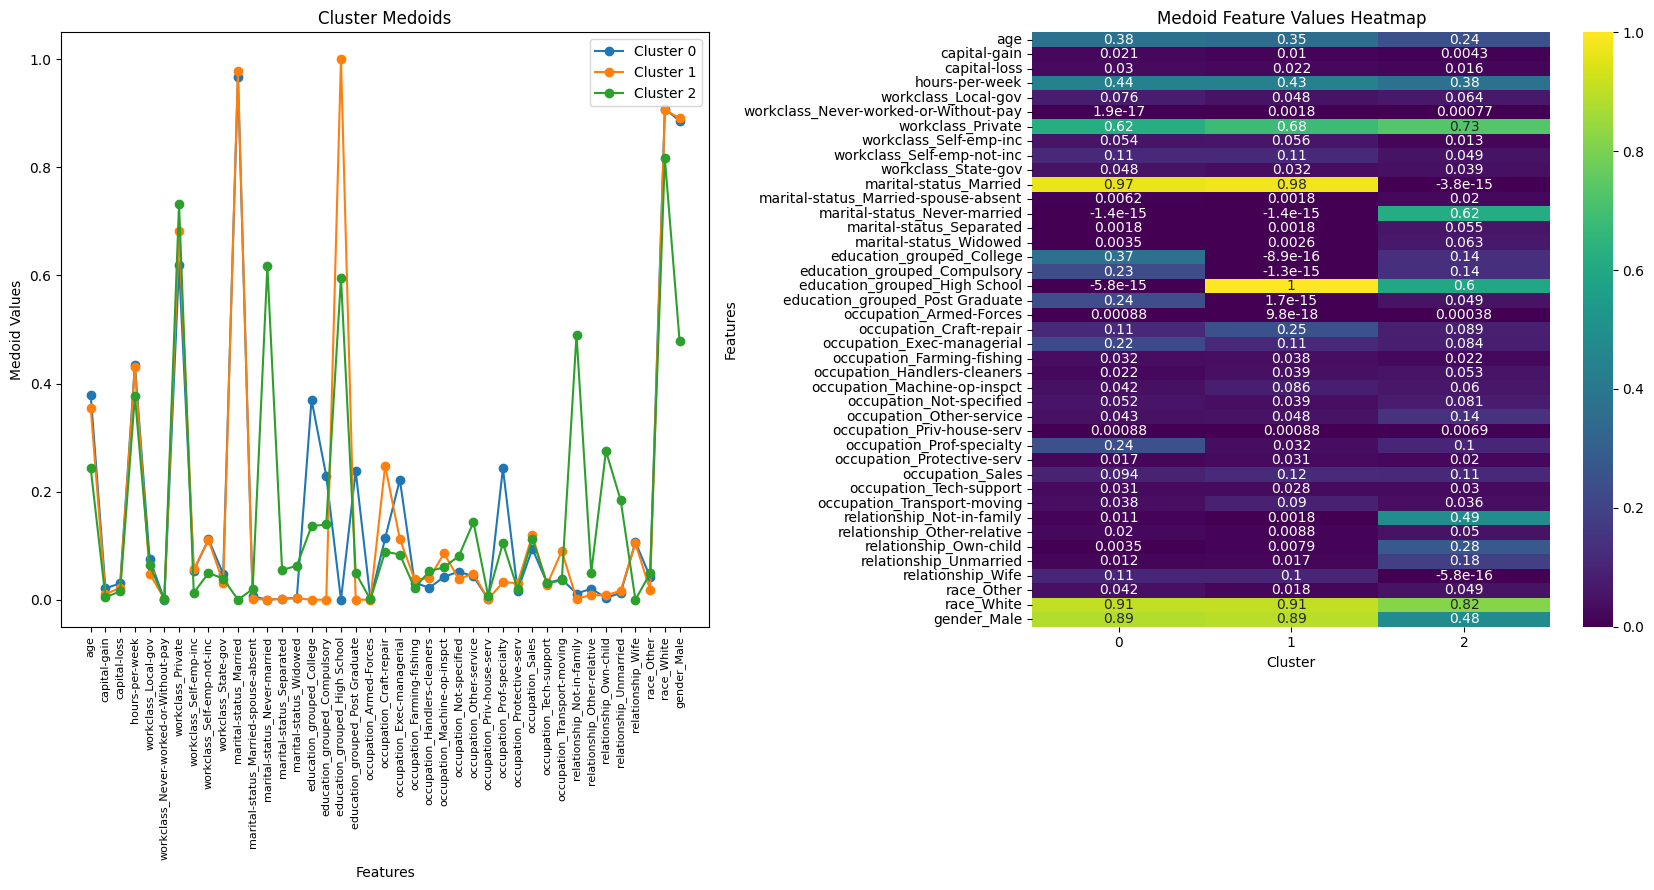

In [ ]:
# Just wanted to check for explainability
mean = kmeans_census.cluster_centers_
mean_df = pd.DataFrame(mean, columns=X.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 9))
for i in range(len(mean)):
    ax1.plot(mean_df.columns, mean_df.iloc[i], marker='o', label=f'Cluster {i}')
ax1.set_title('Cluster Medoids')
ax1.set_xlabel('Features')
ax1.set_ylabel('Medoid Values')
ax1.legend()
ax1.set_xticklabels(mean_df.columns, rotation=90, fontsize=8)

sns.heatmap(mean_df.T, annot=True, cmap="viridis", ax=ax2)
ax2.set_title('Medoid Feature Values Heatmap')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Features')

plt.tight_layout()
plt.show()

## KMedoids

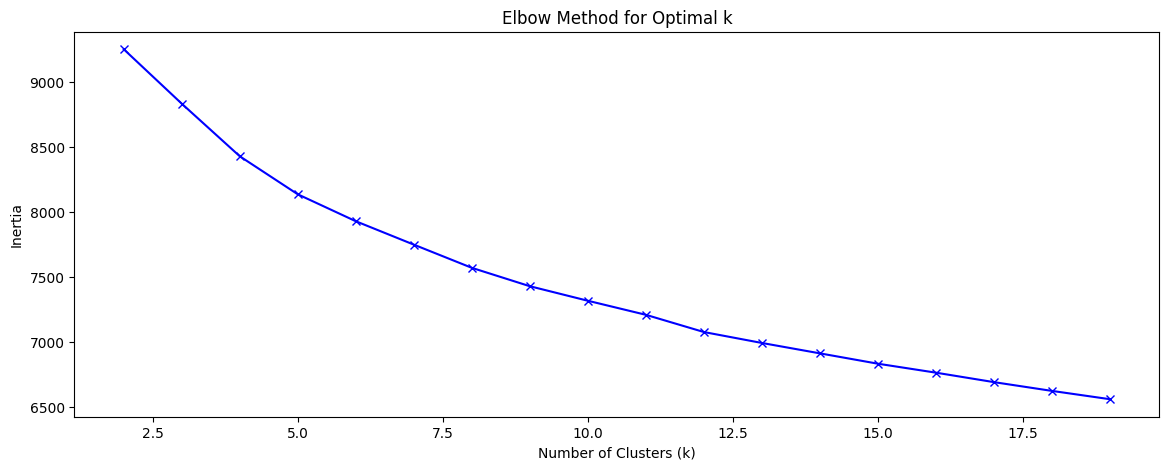

In [ ]:
inertia_values = []

# Try different values of k
k_range = range(2, 20)  # Adjust the range as needed

for k in k_range:
    kmedoids_census = KMedoids(n_clusters=k, method="pam", random_state=42)
    kmedoids_census.fit_predict(X_2)
    inertia_values.append(kmedoids_census.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(14, 5))
plt.plot(k_range, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

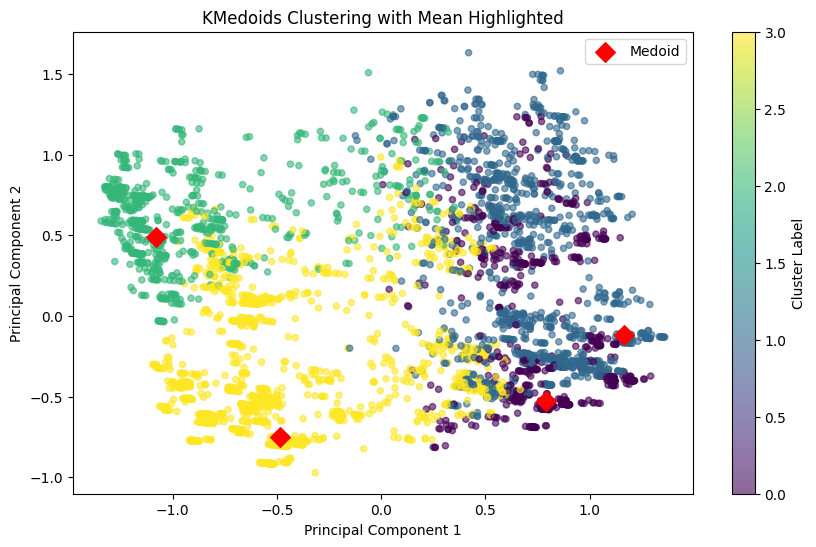

In [ ]:
kmedoids_census = KMedoids(n_clusters=4, method="pam", random_state=42)
y_predict_census = kmedoids_census.fit_predict(X_2)

kmedoids_census_centroids_new = pca.transform(
    kmedoids_census.cluster_centers_
)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=y_predict_census, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.scatter(
    kmedoids_census_centroids_new[:, 0], kmedoids_census_centroids_new[:, 1],
    color='red', marker='D', s=100, label='Medoid'  # Marker style, size, and label
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMedoids Clustering with Mean Highlighted')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

In [ ]:
db_kmedoids = davies_bouldin_score(X_2, y_predict_census)
ch_kmedoids = calinski_harabasz_score(X_2, y_predict_census)
silhouette_kmedoids = silhouette_score(X_2, y_predict_census)

# Print the metrics
print(f"Davies-Bouldin Index for KMedoids with k=4: {db_kmedoids}")
print(f"Calinski-Harabasz Index for KMedoids with k=4: {ch_kmedoids}")
print(f"Silhouette Score for KMedoids with k=4: {silhouette_kmedoids}")

Davies-Bouldin Index for KMedoids with k=4: 2.525237548139109
Calinski-Harabasz Index for KMedoids with k=4: 492.3782525482584
Silhouette Score for KMedoids with k=4: 0.11351101763695437


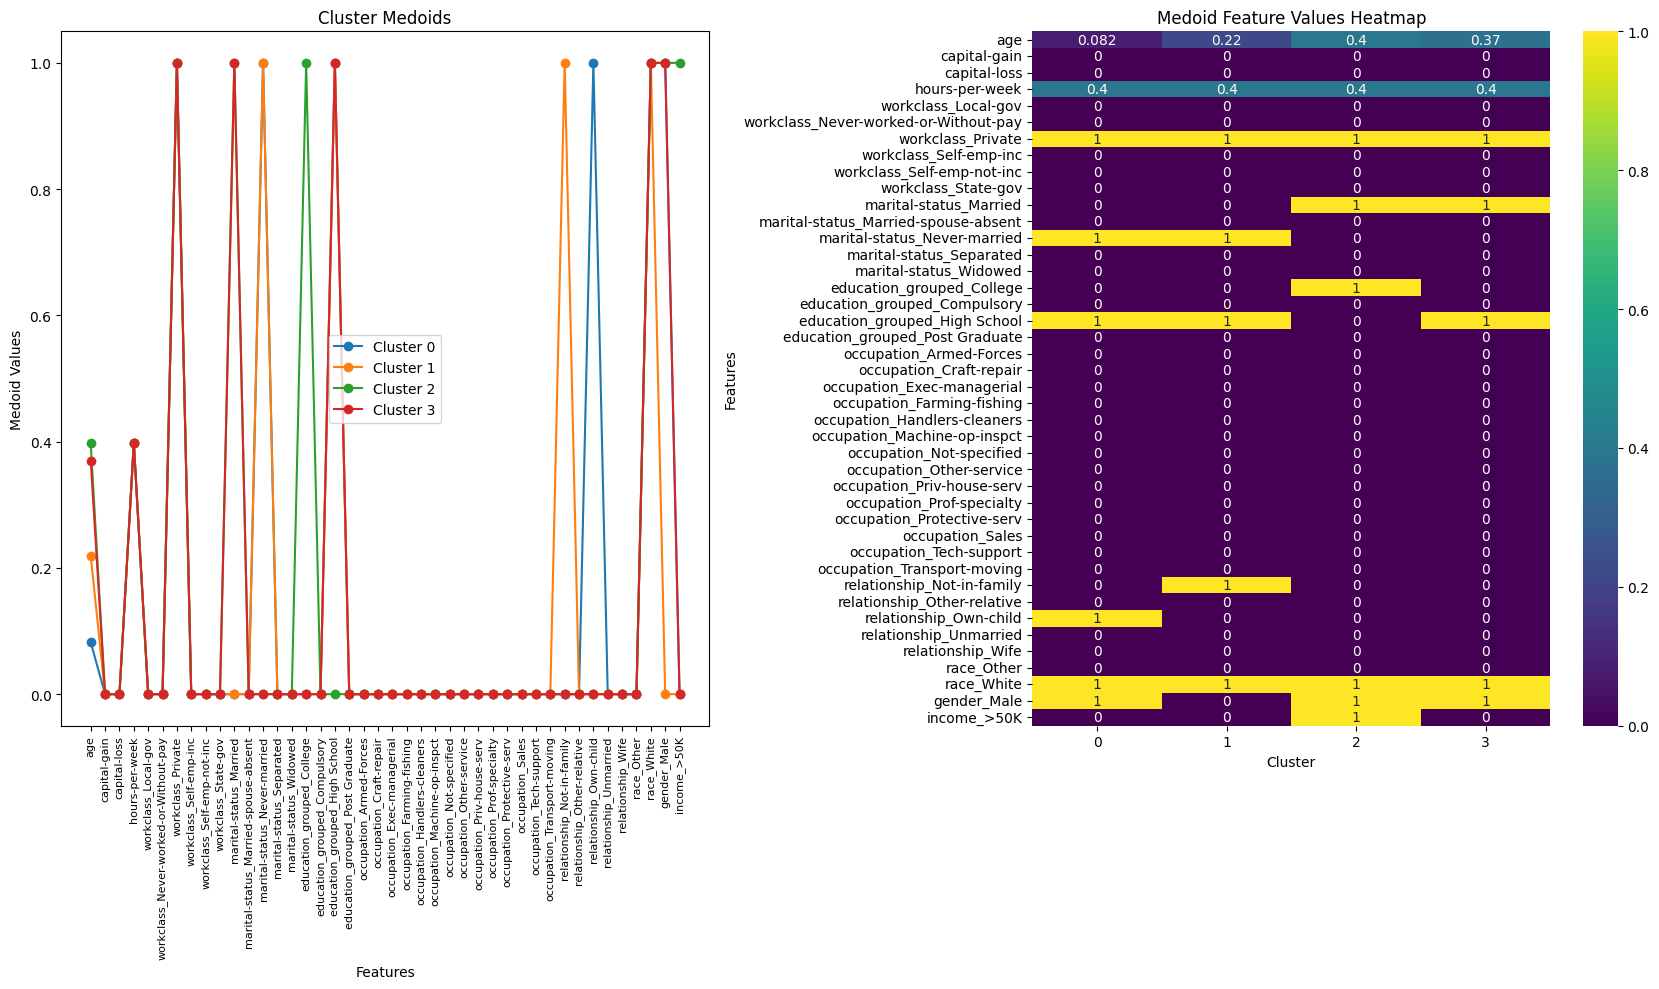

In [ ]:
# Just wanted to check for explainability
medoids = kmedoids_census.cluster_centers_
medoids_df = pd.DataFrame(medoids, columns=X_2.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 10))
for i in range(len(medoids)):
    ax1.plot(medoids_df.columns, medoids_df.iloc[i], marker='o', label=f'Cluster {i}')
ax1.set_title('Cluster Medoids')
ax1.set_xlabel('Features')
ax1.set_ylabel('Medoid Values')
ax1.legend()
ax1.set_xticklabels(medoids_df.columns, rotation=90, fontsize=8)

sns.heatmap(medoids_df.T, annot=True, cmap="viridis", ax=ax2)
ax2.set_title('Medoid Feature Values Heatmap')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Features')

plt.tight_layout()
plt.show()

# Hierarchical-based clustering

In [ ]:
def plot1(Z):
    fig, ax = plt.subplots()
    dn = dendrogram(Z, ax=ax,truncate_mode='level', p=8)
    ax.set_ylabel(r"$\Delta$")
    return ax

<Axes: ylabel='$\\Delta$'>

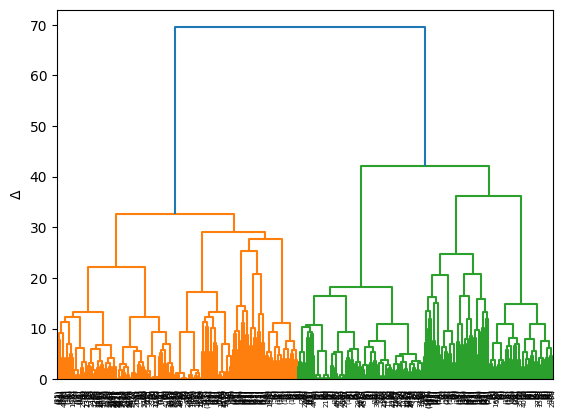

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_2, method='ward', optimal_ordering=True)
plot1(Z)

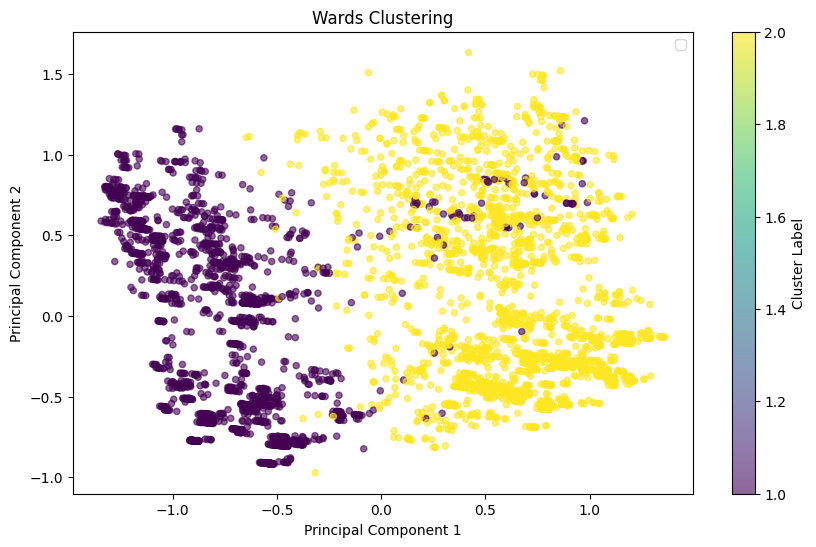

In [ ]:
from scipy.cluster.hierarchy import fcluster

y_predict = fcluster(Z, t=45, criterion="distance")

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=y_predict, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Wards Clustering')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

In [ ]:
silhouette_ward = silhouette_score(X_2, y_predict)
print(f"Silhouette Score for Ward's method clustering: {silhouette_ward}")

Silhouette Score for Ward's method clustering: 0.14482882307159428


In [ ]:
stratified_sample['hierarchical_clusters'] = y_predict

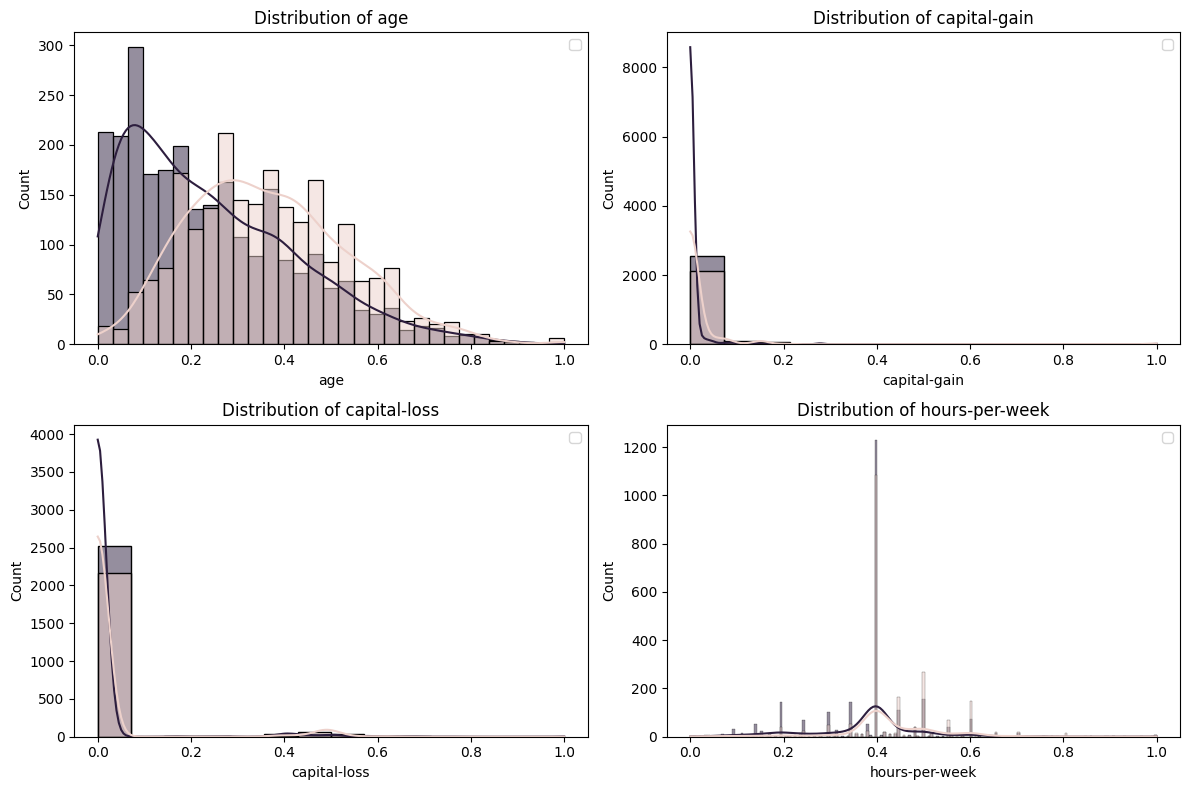

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(data=stratified_sample, x=column, hue='hierarchical_clusters', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

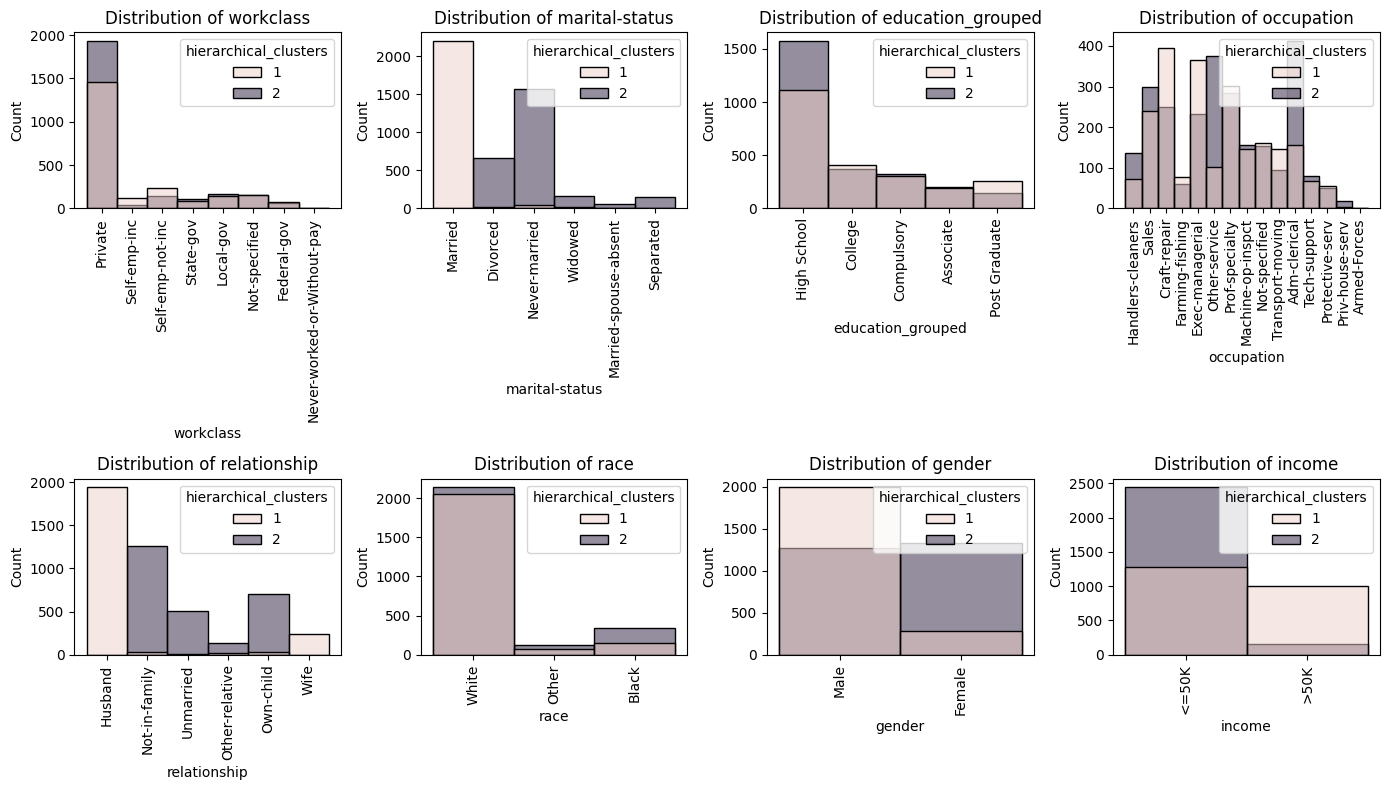

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
axes = axes.flatten()

for i, column in enumerate(categorical_cols):
    sns.histplot(data=stratified_sample, x=column, hue='hierarchical_clusters', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
original_df = data['income_>50K']
cluster_df = stratified_sample['hierarchical_clusters']

# Perform the t-test:
t_stat, p_value = stats.ttest_ind(original_df, cluster_df)

# Interpret the results:
alpha = 0.05
if p_value < alpha:
  print("Reject the null hypothesis; there is a significant difference between the two distributions.")
else:
  print("Fail to reject the null hypothesis; there is no significant difference between the two distributions.")

Reject the null hypothesis; there is a significant difference between the two distributions.


### KMeans for Cluster 2 of the Hierarchical cluster

In [ ]:
X_2_2 = data.copy()
X_2_2['hierarchical_clusters'] = y_predict

In [ ]:
X_2_2 = X_2_2[X_2_2['hierarchical_clusters'] == 2]
X_2_2 = X_2_2.drop(['hierarchical_clusters'], axis=1)

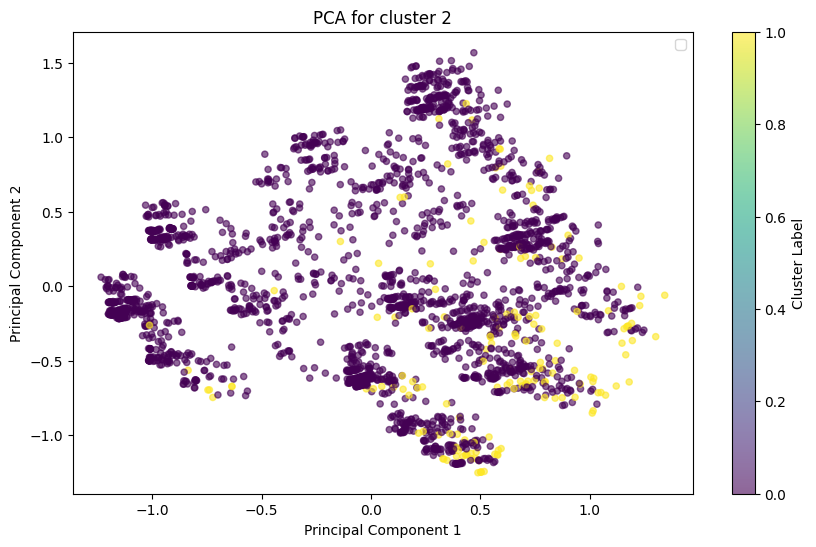

In [ ]:
Y_2_2 = X_2_2['income_>50K']

pca = PCA(n_components=10)
components = pca.fit_transform(X_2_2)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=Y_2_2, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA for cluster 2')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

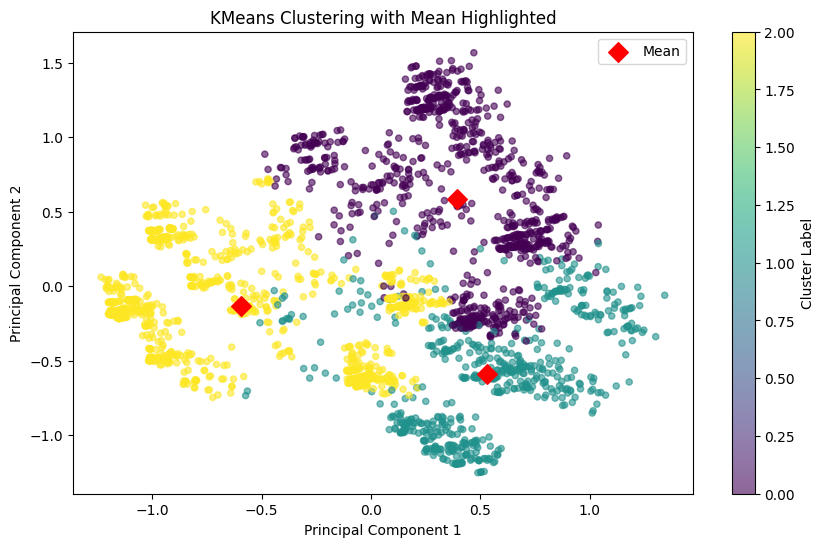

In [ ]:
kmeans_census = KMeans(n_clusters=3, random_state=1337, n_init='auto')
y_predict_census = kmeans_census.fit_predict(X_2_2)

mean_indices = kmeans_census.cluster_centers_ # This gives you coordinates, not indices
mean_pca = pca.transform(mean_indices) # Directly transform the coordinates

# Visualize with Plotly
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=y_predict_census, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.scatter(
    mean_pca[:, 0], mean_pca[:, 1],
    color='red', marker='D', s=100, label='Mean'  # Marker style, size, and label
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with Mean Highlighted')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

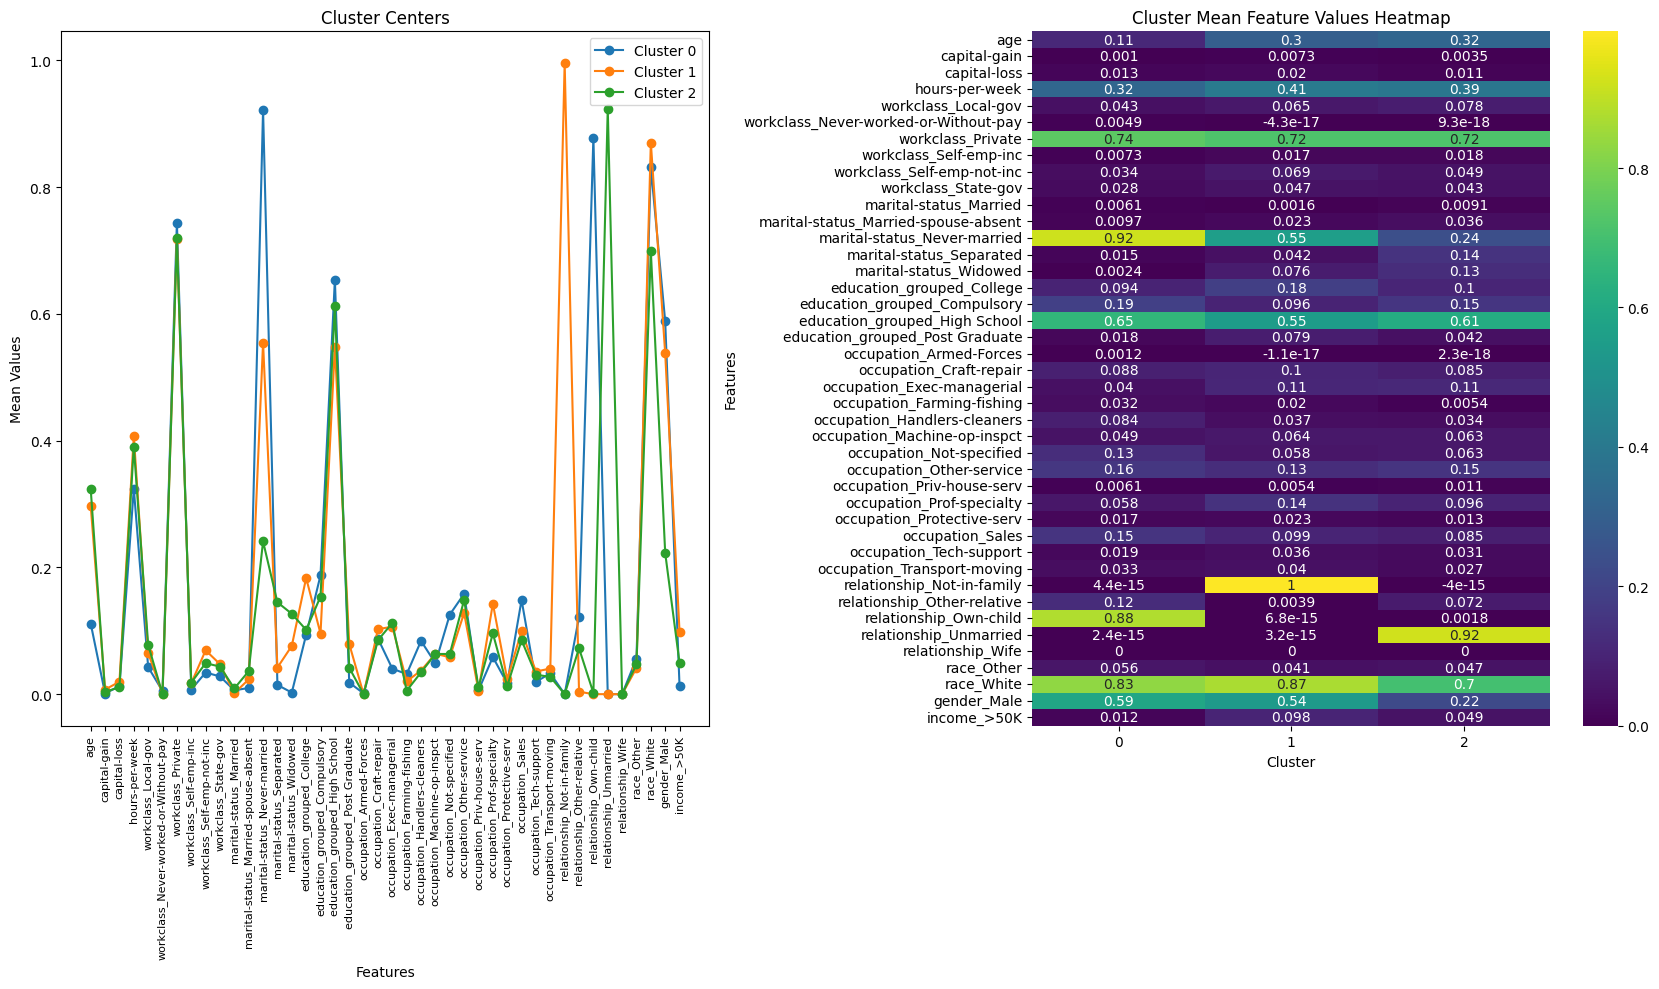

In [ ]:
# Just wanted to check for explainability
mean = kmeans_census.cluster_centers_
mean_df = pd.DataFrame(mean, columns=X_2_2.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 10))
for i in range(len(mean)):
    ax1.plot(mean_df.columns, mean_df.iloc[i], marker='o', label=f'Cluster {i}')
ax1.set_title('Cluster Centers')
ax1.set_xlabel('Features')
ax1.set_ylabel('Mean Values')
ax1.legend()
ax1.set_xticklabels(mean_df.columns, rotation=90, fontsize=8)

sns.heatmap(mean_df.T, annot=True, cmap="viridis", ax=ax2)
ax2.set_title('Cluster Mean Feature Values Heatmap')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Features')

plt.tight_layout()
plt.show()

Cluster 2 (mostly income less than 50K)
Mini-cluster 0: high relationship own child, never married,

### KMeans for Cluster 1 of the Hierarchical cluster

In [ ]:
X_2_2 = data.copy()
X_2_2['hierarchical_clusters'] = y_predict

In [ ]:
X_2_2 = X_2_2[X_2_2['hierarchical_clusters'] == 1]
X_2_2 = X_2_2.drop(['hierarchical_clusters'], axis=1)

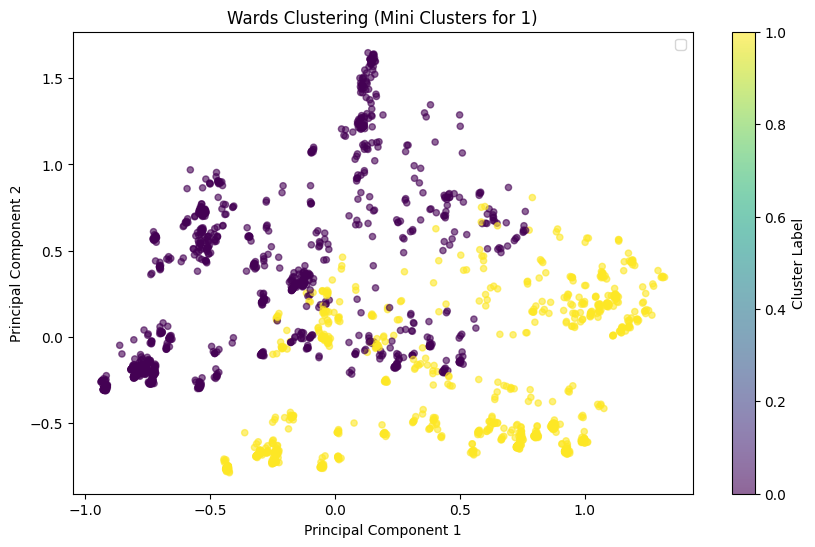

In [ ]:
Y_2_2 = X_2_2['income_>50K']

pca = PCA(n_components=10)
components = pca.fit_transform(X_2_2)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=Y_2_2, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Wards Clustering (Mini Clusters for 1)')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

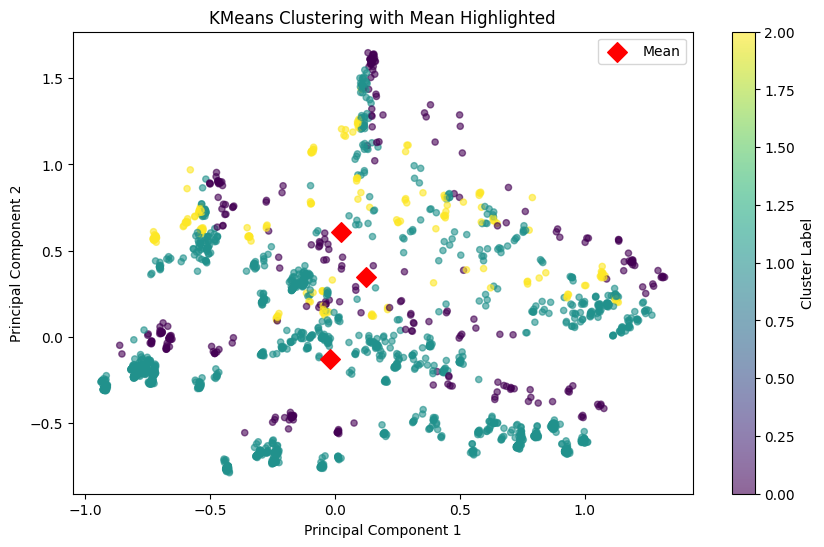

In [ ]:
kmeans_census = KMeans(n_clusters=3, random_state=1337, n_init='auto')
y_predict_census = kmeans_census.fit_predict(X_2_2)

mean_indices = kmeans_census.cluster_centers_ # This gives you coordinates, not indices
mean_pca = pca.transform(mean_indices) # Directly transform the coordinates

# Visualize with Plotly
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=y_predict_census, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.scatter(
    mean_pca[:, 0], mean_pca[:, 1],
    color='red', marker='D', s=100, label='Mean'  # Marker style, size, and label
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with Mean Highlighted')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

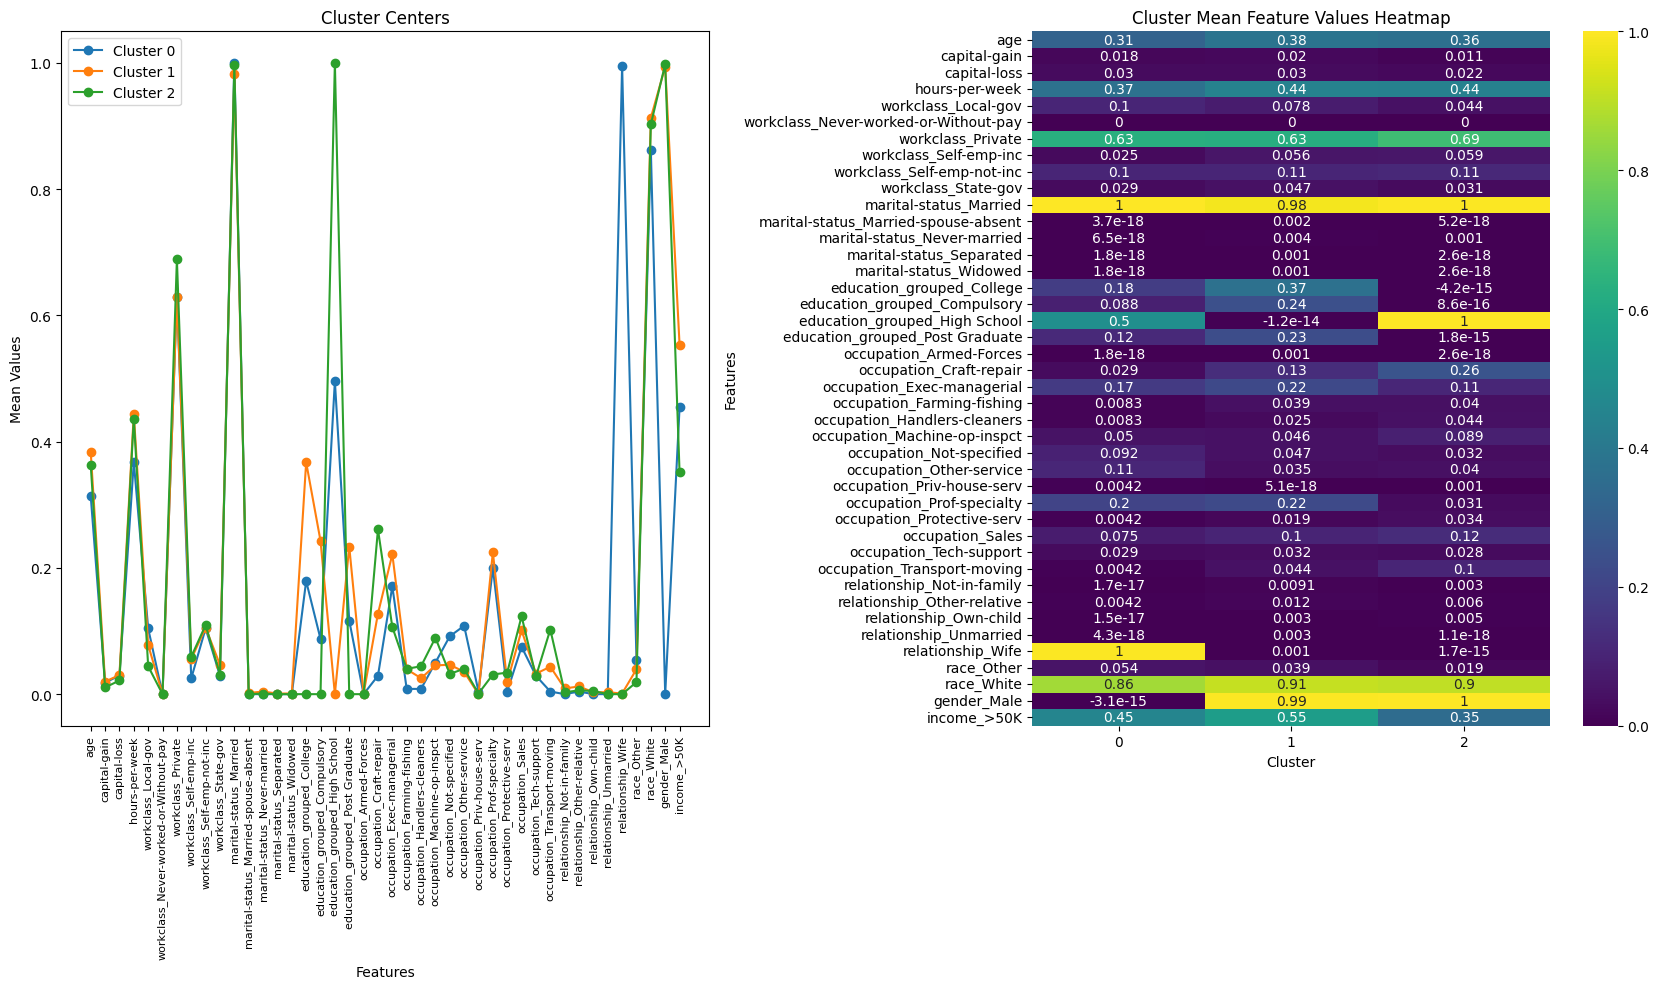

In [ ]:
# Just wanted to check for explainability
mean = kmeans_census.cluster_centers_
mean_df = pd.DataFrame(mean, columns=X_2_2.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 10))
for i in range(len(mean)):
    ax1.plot(mean_df.columns, mean_df.iloc[i], marker='o', label=f'Cluster {i}')
ax1.set_title('Cluster Centers')
ax1.set_xlabel('Features')
ax1.set_ylabel('Mean Values')
ax1.legend()
ax1.set_xticklabels(mean_df.columns, rotation=90, fontsize=8)

sns.heatmap(mean_df.T, annot=True, cmap="viridis", ax=ax2)
ax2.set_title('Cluster Mean Feature Values Heatmap')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Features')

plt.tight_layout()
plt.show()

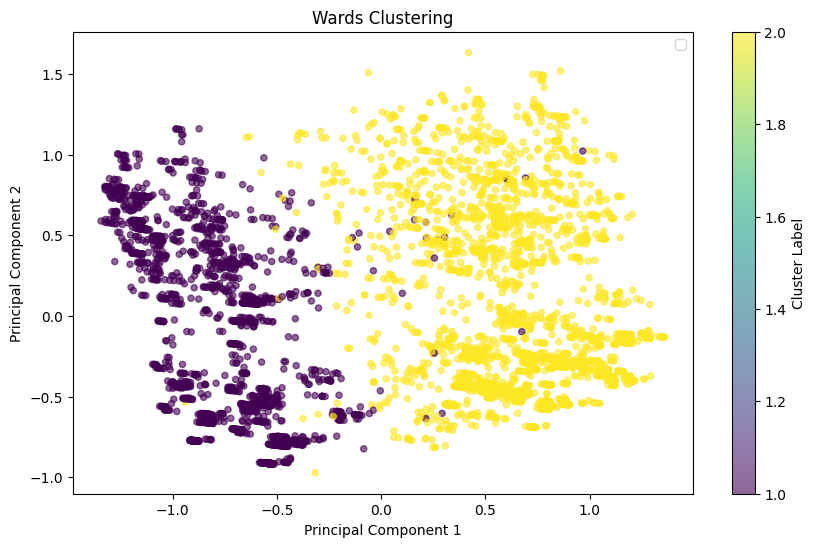

In [ ]:
from scipy.cluster.hierarchy import fcluster

y_predict = fcluster(Z, t=45, criterion="distance")

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=y_predict, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Wards Clustering')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()

# Density-based clustering

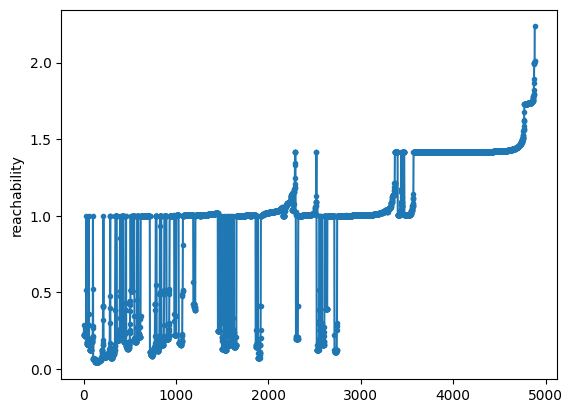

In [38]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

optics = OPTICS(min_samples=20, cluster_method="dbscan")
optics.fit(X_2)
plt.plot(optics.reachability_[optics.ordering_], ".-")
plt.ylabel("reachability");

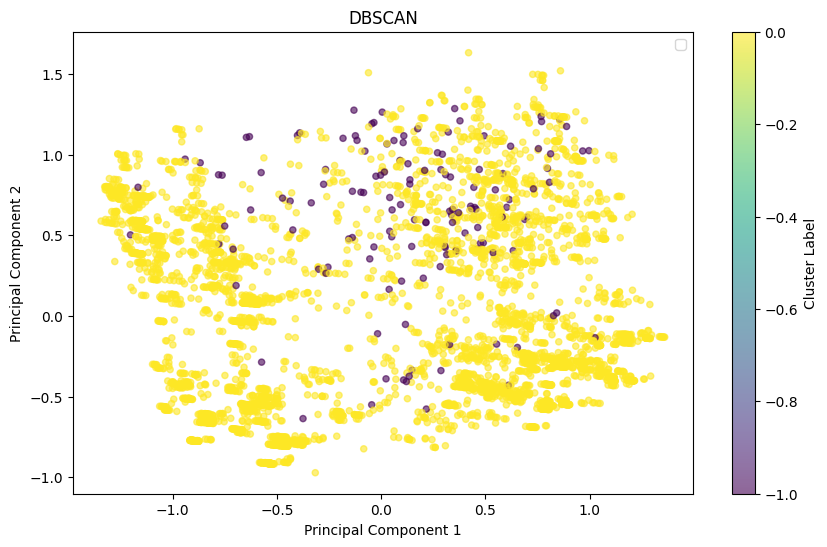

Number of clusters: 1
Number of noise points: 135
Number of points in the largest cluster: 4749
Number of points: 4884
Silhouette score: 0.14270900278544033


In [45]:
cluster_labels = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=1.5,
)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=cluster_labels, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()
print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print("Number of points:", len(cluster_labels))
print("Silhouette score:", silhouette_score(X_2, cluster_labels))

In [40]:
from sklearn.neighbors import NearestNeighbors

def get_kdist(k, data):
    n = data.shape[0]
    distances = []

    for i in range(n):
        # Access the row using .iloc to handle various index ztypes
        point = data.iloc[i].values
        # Convert boolean values to integers before calculating distances
        point = point.astype(int)
        data_int = data.values.astype(int)
        # Calculate Euclidean distances to all other points
        dists = np.sqrt(np.sum((data_int - point)**2, axis=1))
        k_distance = np.sort(dists)[k]
        distances.append(k_distance)

    return sorted(distances, reverse=True)

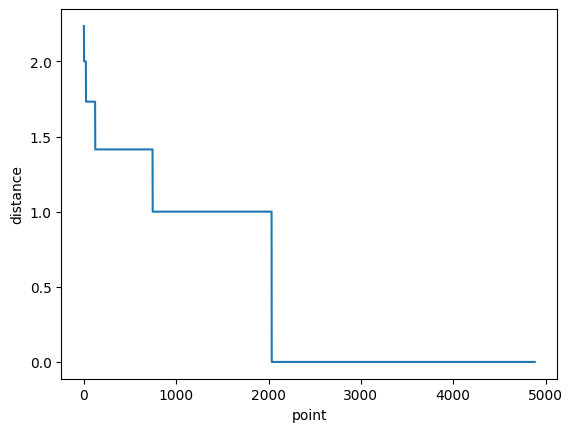

In [41]:
plt.plot(get_kdist(3, X_2))
plt.xlabel("point")
plt.ylabel("distance");

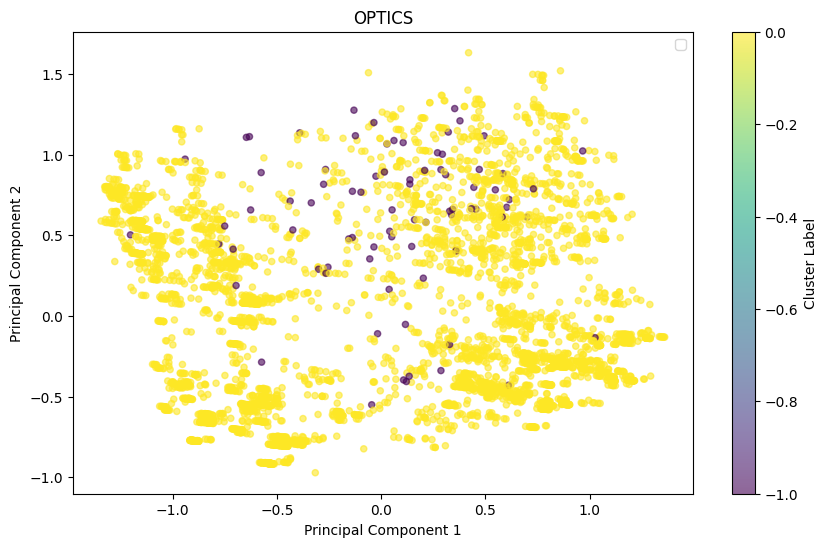

Number of clusters: 1
Number of noise points: 79
Number of points in the largest cluster: 4805
Number of points: 4884
Silhouette score: 0.14767983140078653


In [46]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=9)
cluster_labels = dbscan.fit_predict(X_2)
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=cluster_labels, cmap='viridis',  # Customize colormap as needed
    s=20, alpha=0.6  # Size and opacity of points
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('OPTICS')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.show()
print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print("Number of points:", len(cluster_labels))
print("Silhouette score:", silhouette_score(X_2, cluster_labels))

## <b>Appendix

### <b>UMAP-enhanced Clustering

In [26]:
import kmapper as km
from kmapper import jupyter # custom CSS full-size Jupyter screen
import umap
import sklearn
import sklearn.manifold as manifold
from kmapper import Cover
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import cluster


from sklearn.model_selection import GridSearchCV

### Pre-processing

In [29]:
education_mapping = {
    'Preschool': 'Compulsory',
    '1st-4th': 'Compulsory',
    '5th-6th': 'Compulsory',
    '7th-8th': 'Compulsory',
    '9th': 'Compulsory',
    '10th': 'Compulsory',
    '11th': 'Compulsory',
    '12th': 'Compulsory',
    'HS-grad': 'High School',
    'Some-college': 'High School',
    'Assoc-voc': 'Associate',
    'Assoc-acdm': 'Associate',
    'Bachelors': 'College',
    'Masters': 'Post Graduate',
    'Prof-school': 'Post Graduate',
    'Doctorate': 'Post Graduate'
}

# Apply the mapping to the 'education' column
df['education_grouped'] = df['education'].map(education_mapping)

In [30]:
# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    if row['native-country'] == 'United-States':
        df.loc[index, 'native-country'] = 'United States' # Update the value in the 'native-country' column for this row
    else:
        df.loc[index, 'native-country'] = 'Other' # Update the value in the 'native-country' column for this row

df['native-country'].value_counts()

native-country
United States    43832
Other             5010
Name: count, dtype: int64

In [31]:
from tqdm import tqdm

# Iterate over each row in the DataFrame
for index, row in tqdm(df.iterrows()):
    if row['race'] == 'White':
        df.loc[index, 'race'] = 'White'
    elif row['race'] == 'Black':
        df.loc[index, 'race'] = 'Black'     # Update the value in the 'native-country' column for this row
    else:
        df.loc[index, 'race'] = 'Other' # Update the value in the 'native-country' column for this row

df['race'].value_counts()

48842it [00:25, 1927.11it/s]


race
White    41762
Black     4685
Other     2395
Name: count, dtype: int64

In [32]:
df['workclass'] = df['workclass'].replace(['Never-worked', 'Without-pay'], 'Never-worked-or-Without-pay')

In [33]:
df['marital-status'] = df['marital-status'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'Married')
df['marital-status'].value_counts()

marital-status
Married                  22416
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Name: count, dtype: int64

In [34]:
from sklearn.preprocessing import MinMaxScaler

numerical_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'marital-status', 'education_grouped', 'occupation', 'relationship', 'race', 'gender', 'income']

for i in df.columns:
    df[i].replace({"?":"Not-specified"},inplace=True)

std_scaler = MinMaxScaler()
df[numerical_cols] = std_scaler.fit_transform(df[numerical_cols])

# le = LabelEncoder()
# df['education_grouped_encoded'] = le.fit_transform(df['education_grouped'])

df_final = pd.concat([df[numerical_cols], df[categorical_cols]], axis=1)

# One-hot encode categorical columns
data = pd.get_dummies(df_final, columns=categorical_cols, drop_first=True)

### Dimensionality Reduction (Uniform Manifold Approximation and Projection)

In [36]:
X_2 = data
y_2 = data["income_>50K"]

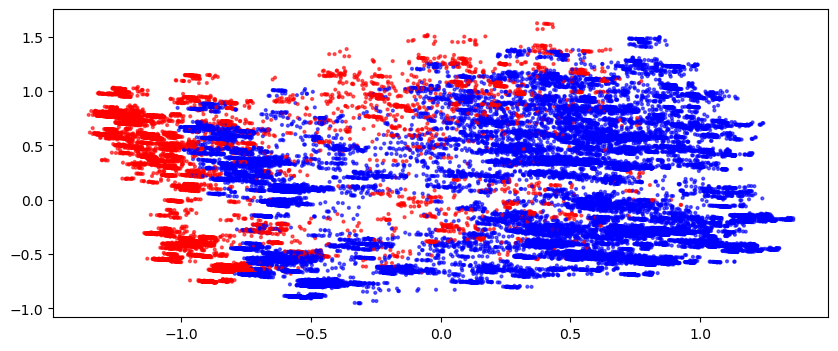

In [37]:
#projection in PCA

import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
components = pca.fit_transform(X_2)

plt.figure(figsize=(10, 4))
plt.scatter(components[:, 0], components[:, 1], c=y_2, s=4, cmap='bwr', alpha=0.6);
#fig = px.scatter(components, x=0, y=1, color=y_2)
#fig.show()

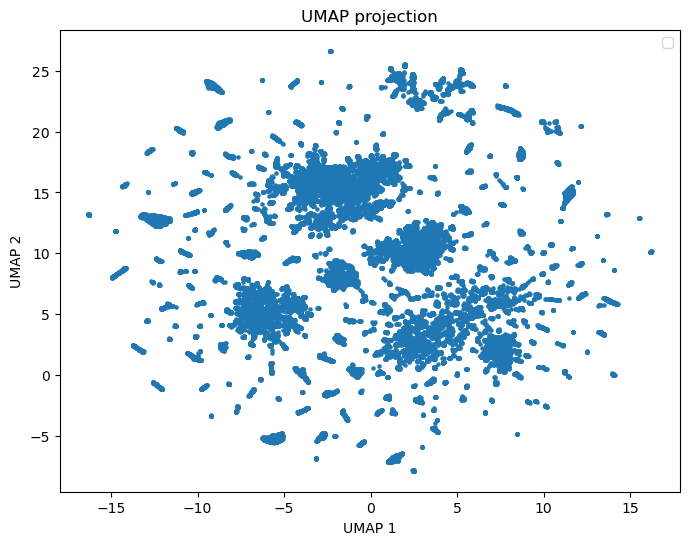

In [39]:
# income inlcuded 
#classes = ["greater than_50K", "less_than_50k"]
# assuming the ground truth are the greater than and less than 50k
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0.2, metric='euclidean', n_components=2, unique=True)
X_umap = umap_reducer.fit_transform(X_2)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], #c=y,
                      cmap='Spectral', s=5)
plt.title('UMAP projection')
plt.legend(*scatter.legend_elements())
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### Sampling of dataset to perform clustering

In [40]:
# Sample 5000 datapoints
X_umap_sampled = X_umap[np.random.choice(X_umap.shape[0], 5000, replace=True)]

# Now `sampled_data` contains 5000 randomly sampled data points
print(X_umap_sampled.shape)  # This should output (5000, 2)

(5000, 2)


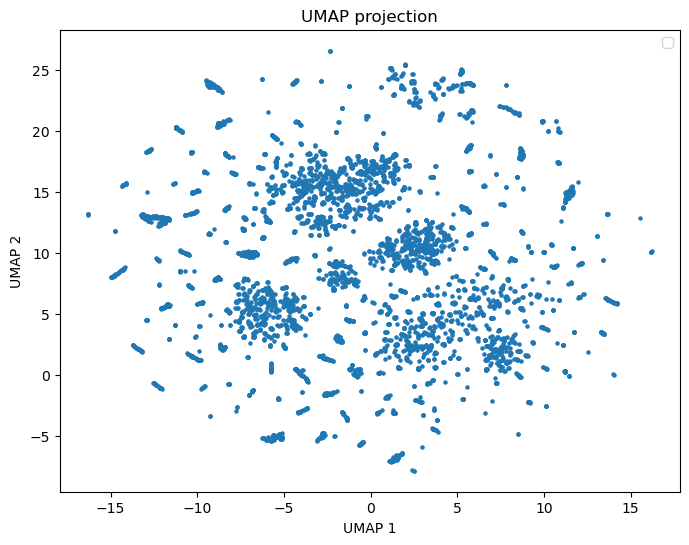

In [41]:
# income inlcuded 
#classes = ["greater than_50K", "less_than_50k"]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap_sampled[:, 0], X_umap_sampled[:, 1], #c=y,
                      cmap='Spectral', s=5)
plt.title('UMAP projection')
plt.legend(*scatter.legend_elements())
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## Using Agglomerative Clustering

In [47]:
# values of t
thresholds = np.arange(2, 15, 1)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
sum_of_squared_distances = []

#use AgglomerativeClustering function sklearn
for t in thresholds:
    clustering = cluster.AgglomerativeClustering(n_clusters=t, linkage='ward')
    labels = clustering.fit_predict(X_umap_sampled)
    #if (t*100)%10==0:
    print(f'No. of clusters: {np.unique(labels).size}')
    
    silhouette_avg = silhouette_score(X_umap_sampled, labels)
    davies_bouldin_avg = davies_bouldin_score(X_umap_sampled, labels)
    calinski_harabasz_avg = calinski_harabasz_score(X_umap_sampled, labels)
    
    # calculate sum of squared distances
    ssd = 0
    for i in np.unique(labels):
        cluster_points = X_umap_sampled[labels == i]
        centroid = cluster_points.mean(axis=0)
        ssd += np.sum((cluster_points - centroid) ** 2)

    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)
    calinski_harabasz_scores.append(calinski_harabasz_avg)
    sum_of_squared_distances.append(ssd)

No. of clusters: 2
No. of clusters: 3
No. of clusters: 4
No. of clusters: 5
No. of clusters: 6
No. of clusters: 7
No. of clusters: 8
No. of clusters: 9
No. of clusters: 10
No. of clusters: 11
No. of clusters: 12
No. of clusters: 13
No. of clusters: 14


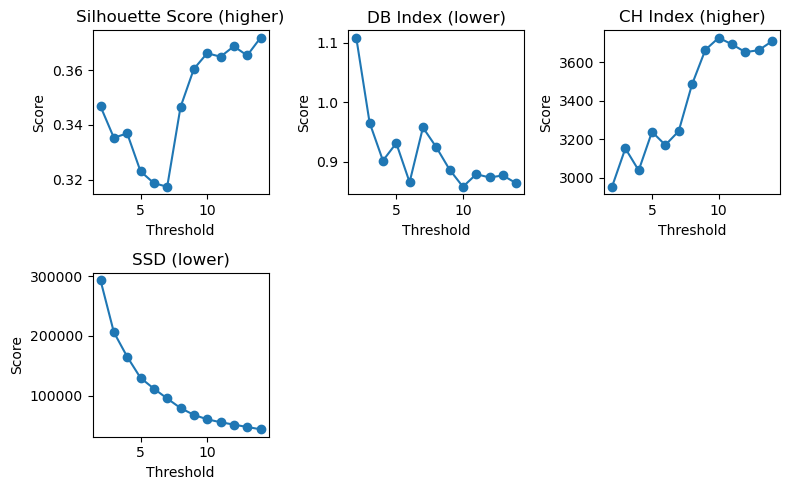

In [48]:
metrics = [
    ("Silhouette Score (higher)", silhouette_scores),
    ("DB Index (lower)", davies_bouldin_scores),
    ("CH Index (higher)", calinski_harabasz_scores),
    ("SSD (lower)", sum_of_squared_distances), 
    #("Purity Score (higher)", purity_scores)
]

plt.figure(figsize=(8, 5))

for i, (title, values) in enumerate(metrics, start=1):
    plt.subplot(2, 3, i)
    plt.plot(thresholds, values, marker='o')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel('Score')

plt.tight_layout()
plt.show()

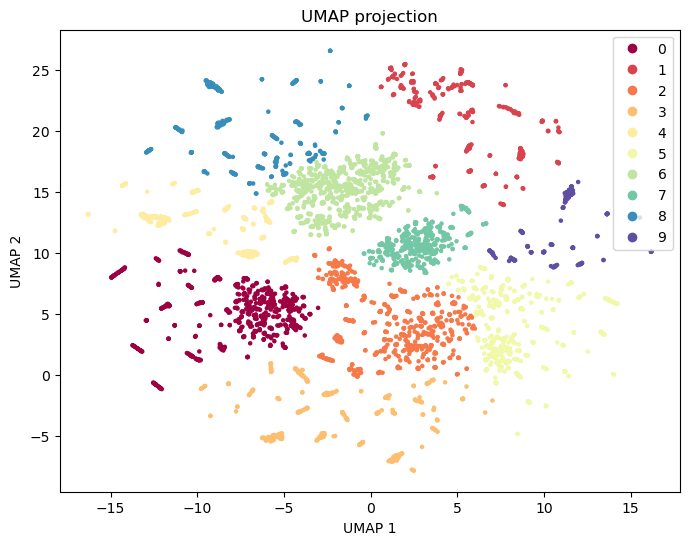

In [49]:
agg = cluster.AgglomerativeClustering(
    n_clusters=10, linkage="ward"
)
y_umap = agg.fit_predict(X_umap_sampled)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap_sampled[:, 0], X_umap_sampled[:, 1], c=y_umap,
                      cmap='Spectral', s=5)
plt.title('UMAP projection')
plt.legend(*scatter.legend_elements())
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### Using OPTICS

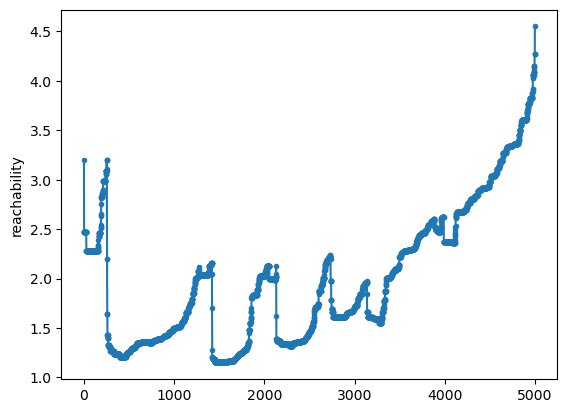

In [50]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

optics = OPTICS(min_samples=150, cluster_method="dbscan")
optics.fit(X_umap_sampled)
plt.plot(optics.reachability_[optics.ordering_], ".-")
plt.ylabel("reachability");

Number of clusters: 2
Number of noise points: 510
Number of points in the largest cluster: 4253
Number of points: 5000
Silhouette score: 0.21848038


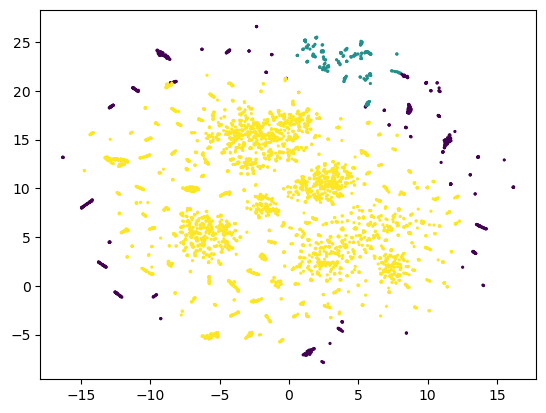

In [53]:
cluster_labels = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=3.0,
)
plt.scatter(X_umap_sampled[:, 0], X_umap_sampled[:, 1], c=cluster_labels, s=1.7)
print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print("Number of points:", len(cluster_labels))
print("Silhouette score:", silhouette_score(X_umap_sampled, cluster_labels))

### Using KMedoids

In [43]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# values of t
thresholds = np.arange(2, 15, 1)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
sum_of_squared_distances = []

# Use KMedoids clustering
for t in thresholds:
    clustering = KMedoids(n_clusters=t, method='pam', random_state=42)
    labels = clustering.fit_predict(X_umap_sampled)
    
    print(f'No. of clusters: {np.unique(labels).size}')
    
    silhouette_avg = silhouette_score(X_umap_sampled, labels)
    davies_bouldin_avg = davies_bouldin_score(X_umap_sampled, labels)
    calinski_harabasz_avg = calinski_harabasz_score(X_umap_sampled, labels)
    
    # calculate sum of squared distances
    ssd = 0
    for i in np.unique(labels):
        cluster_points = X_umap_sampled[labels == i]
        medoid = clustering.cluster_centers_[i]
        ssd += np.sum((cluster_points - medoid) ** 2)

    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)
    calinski_harabasz_scores.append(calinski_harabasz_avg)
    sum_of_squared_distances.append(ssd)


No. of clusters: 2
No. of clusters: 3
No. of clusters: 4
No. of clusters: 5
No. of clusters: 6
No. of clusters: 7
No. of clusters: 8
No. of clusters: 9
No. of clusters: 10
No. of clusters: 11
No. of clusters: 12
No. of clusters: 13
No. of clusters: 14


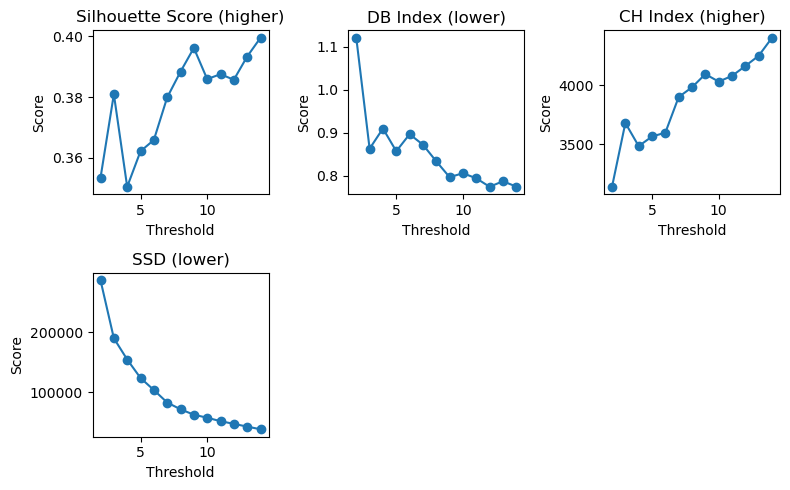

In [44]:
metrics = [
    ("Silhouette Score (higher)", silhouette_scores),
    ("DB Index (lower)", davies_bouldin_scores),
    ("CH Index (higher)", calinski_harabasz_scores),
    ("SSD (lower)", sum_of_squared_distances), 
    #("Purity Score (higher)", purity_scores)
]

plt.figure(figsize=(8, 5))

for i, (title, values) in enumerate(metrics, start=1):
    plt.subplot(2, 3, i)
    plt.plot(thresholds, values, marker='o')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel('Score')

plt.tight_layout()
plt.show()

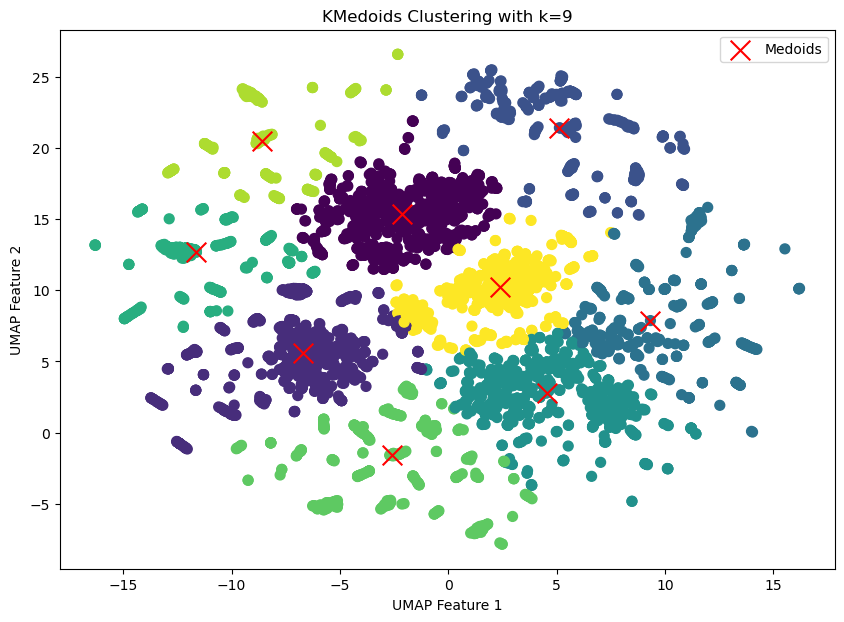

In [46]:
best_k = 9

best_clustering = KMedoids(n_clusters=best_k, method='pam', random_state=42)
best_labels = best_clustering.fit_predict(X_umap_sampled)

# Step 3: Plot the dataset with the clustering results
plt.figure(figsize=(10, 7))
plt.scatter(X_umap_sampled[:, 0], X_umap_sampled[:, 1], c=best_labels, cmap='viridis', marker='o', s=50)
plt.scatter(best_clustering.cluster_centers_[:, 0], best_clustering.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, label='Medoids')

plt.title(f'KMedoids Clustering with k={best_k}')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.legend()
plt.show()